In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/ExportedFiles-20250617T093649Z-1-001.zip"
extract_to = "/content/drive/MyDrive/ExportedFiles"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipped successfully to:", extract_to)


Unzipped successfully to: /content/drive/MyDrive/ExportedFiles


In [ ]:
!pip install pynrrd


#DATA PREPARATION

##Exloration one example

In [ ]:
import numpy as np
import nrrd
import matplotlib.pyplot as plt

# Load image and mask
image_path = '/content/drive/MyDrive/ExportedFiles/ExportedFiles/01226937axial.nrrd'
mask_path = '/content/drive/MyDrive/ExportedFiles/ExportedFiles/01226937.seg.nrrd'

image_data, _ = nrrd.read(image_path)
mask_data, _ = nrrd.read(mask_path)

# Print original shape
print(f"Original Mask Unique Values: {np.unique(mask_data)}")

# Binarize the mask: convert all non-zero labels to 1
binary_mask = (mask_data > 0).astype(np.uint8)

print(f"Binarized Mask Unique Values: {np.unique(binary_mask)}")

# Visualize a few slices
num_slices = image_data.shape[2]
for i in range(num_slices):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_data[:, :, i], cmap='gray')
    plt.title(f'Image Slice {i}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask[:, :, i], cmap='gray')
    plt.title(f'Binary Mask Slice {i}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

###Step1:Image-Mask Pairing and Renaming

In [ ]:
import os, re, shutil
from pathlib import Path

# ====== 1) CONFIGURE THESE THREE PATHS IF NEEDED ======
SRC_DIR   = Path("/content/drive/MyDrive/ExportedFiles/ExportedFiles")
DEST_ROOT = Path("/content/drive/MyDrive/SQU_prepared_data")
IMG_DIR   = DEST_ROOT / "images"
MSK_DIR   = DEST_ROOT / "masks"
# ======================================================

# Create destination folders
IMG_DIR.mkdir(parents=True, exist_ok=True)
MSK_DIR.mkdir(parents=True, exist_ok=True)

# Helper regex: grab the leading run of 6‑8 digits
id_re = re.compile(r"^(\d{6,8})")

image_map = {}   # ID -> axial‑image path
mask_map  = {}   # ID -> seg‑mask  path

for entry in SRC_DIR.glob("*.nrrd"):
    m = id_re.match(entry.name)
    if not m:
        continue
    uid = m.group(1)
    lower = entry.name.lower()

    # classify file
    if lower.endswith(".seg.nrrd"):
        mask_map[uid] = entry
    elif "axial" in lower:                 # catches axial / axialcuts / axial...
        image_map[uid] = entry

# keep IDs that have *both* an image and a mask
common_ids = sorted(set(image_map) & set(mask_map))

print(f"Found {len(common_ids)} complete cases")

for new_idx, uid in enumerate(common_ids, start=1):
    new_img_name  = f"{new_idx:03d}.nrrd"
    new_mask_name = f"{new_idx:03d}.seg.nrrd"

    shutil.copy2(image_map[uid], IMG_DIR / new_img_name)
    shutil.copy2(mask_map[uid],  MSK_DIR / new_mask_name)

print("Done!  Images in", IMG_DIR, "— Masks in", MSK_DIR)


Found 54 complete cases
✅ Done!  Images in /content/drive/MyDrive/SQU_prepared_data/images — Masks in /content/drive/MyDrive/SQU_prepared_data/masks


###Step 2:Quality Check: Anatomical Orientation Consistency

In [ ]:
import os
import numpy as np
import nrrd
import matplotlib.pyplot as plt
from pathlib import Path

# Paths to prepared image and mask folders
image_dir = Path("/content/drive/MyDrive/SQU_prepared_data/images")
mask_dir  = Path("/content/drive/MyDrive/SQU_prepared_data/masks")

# Get all image files
image_files = sorted(image_dir.glob("*.nrrd"))

print(f"Found {len(image_files)} image files")

for img_path in image_files:
    # Get corresponding mask
    idx = img_path.stem  # e.g., "001"
    mask_path = mask_dir / f"{idx}.seg.nrrd"
    if not mask_path.exists():
        print(f" Missing mask for {img_path.name}")
        continue

    # Read image and mask
    image_data, _ = nrrd.read(img_path)
    mask_data, _  = nrrd.read(mask_path)

    # Binarize mask
    binary_mask = (mask_data > 0).astype(np.uint8)

    # Get center slice index
    center_slice = image_data.shape[2] // 2

    # Plot center slice
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Case: {idx}", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.imshow(image_data[:, :, center_slice], cmap='gray')
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask[:, :, center_slice], cmap='gray')
    plt.title("Binarized Mask")
    plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

conclusion:All Abdomen CT point to left


###Step3:Checking Volume Dimensions: Height, Width, and Slice Count for all CTs


In [ ]:
import nrrd
from pathlib import Path

# Paths to prepared image and mask folders
image_dir = Path("/content/drive/MyDrive/SQU_prepared_data/images")
mask_dir  = Path("/content/drive/MyDrive/SQU_prepared_data/masks")

image_files = sorted(image_dir.glob("*.nrrd"))

print(f"{'Case':<6} | {'Image Shape':<20} | {'Mask Shape':<20} | Status")
print("-" * 70)

for img_path in image_files:
    case_id = img_path.stem
    mask_path = mask_dir / f"{case_id}.seg.nrrd"

    if not mask_path.exists():
        print(f"{case_id:<6} | {'MISSING':<20} | {'MISSING':<20} | Missing mask")
        continue

    img_data, _ = nrrd.read(img_path)
    mask_data, _ = nrrd.read(mask_path)

    img_shape = img_data.shape
    mask_shape = mask_data.shape

    status = "Match" if img_shape == mask_shape else "Mismatch"
    print(f"{case_id:<6} | {str(img_shape):<20} | {str(mask_shape):<20} | {status}")


Case   | Image Shape          | Mask Shape           | Status
----------------------------------------------------------------------
001    | (512, 512, 143)      | (512, 512, 143)      | Match
002    | (512, 512, 157)      | (512, 512, 157)      | Match
003    | (512, 512, 131)      | (512, 512, 131)      | Match
004    | (512, 512, 158)      | (512, 512, 158)      | Match
005    | (512, 512, 140)      | (512, 512, 140)      | Match
006    | (512, 512, 152)      | (512, 512, 152)      | Match
007    | (512, 512, 153)      | (512, 512, 153)      | Match
008    | (512, 512, 134)      | (512, 512, 134)      | Match
009    | (512, 512, 166)      | (512, 512, 166)      | Match
010    | (512, 512, 148)      | (512, 512, 148)      | Match
011    | (512, 512, 150)      | (512, 512, 150)      | Match
012    | (512, 512, 155)      | (512, 512, 155)      | Match
013    | (512, 512, 160)      | (512, 512, 160)      | Match
014    | (512, 512, 169)      | (512, 512, 169)      | Match
015    | (512

###Step4: Compute Intensity Ranges for each case

In [ ]:
import nrrd
import numpy as np
from pathlib import Path

# Directories
image_dir = Path("/content/drive/MyDrive/SQU_prepared_data/images")
mask_dir  = Path("/content/drive/MyDrive/SQU_prepared_data/masks")

image_files = sorted(image_dir.glob("*.nrrd"))

print(f"{'Case':<6} | {'Image Min':>10} | {'Image Max':>10} | {'Mask Values':<20}")
print("-" * 60)

for img_path in image_files:
    case_id = img_path.stem
    mask_path = mask_dir / f"{case_id}.seg.nrrd"

    if not mask_path.exists():
        print(f"{case_id:<6} | {'MISSING':>10} | {'MISSING':>10} | Missing mask")
        continue

    # Read image and mask
    img_data, _ = nrrd.read(img_path)
    mask_data, _ = nrrd.read(mask_path)

    # Binarize the mask
    binary_mask = (mask_data > 0).astype(np.uint8)

    # Intensity range of image
    img_min = np.min(img_data)
    img_max = np.max(img_data)

    # Unique values in binarized mask
    mask_values = np.unique(binary_mask)

    print(f"{case_id:<6} | {img_min:>10.1f} | {img_max:>10.1f} | {mask_values}")




Case   |  Image Min |  Image Max | Mask Values         
------------------------------------------------------------
001    |    -1024.0 |     3071.0 | [0 1]
002    |    -1024.0 |     1410.0 | [0 1]
003    |    -1024.0 |     3071.0 | [0 1]
004    |    -1024.0 |     1651.0 | [0 1]
005    |    -1024.0 |     1640.0 | [0 1]
006    |    -1024.0 |     1644.0 | [0 1]
007    |    -1024.0 |     2222.0 | [0 1]
008    |    -1024.0 |     3068.0 | [0 1]
009    |    -1024.0 |     2650.0 | [0 1]
010    |    -1024.0 |     1579.0 | [0 1]
011    |    -1024.0 |     1501.0 | [0 1]
012    |    -1024.0 |     3071.0 | [0 1]
013    |    -1024.0 |     1443.0 | [0 1]
014    |    -1024.0 |     1484.0 | [0 1]
015    |    -1024.0 |     1669.0 | [0 1]
016    |    -1024.0 |     1751.0 | [0 1]
017    |    -1024.0 |     1492.0 | [0 1]
018    |    -1024.0 |     1970.0 | [0 1]
019    |    -1024.0 |     1673.0 | [0 1]
020    |    -1024.0 |     1602.0 | [0 1]
021    |    -1024.0 |     1565.0 | [0 1]
022    |    -1024.0 | 

Conclusion:All CT image volumes share a consistent minimum intensity of -1024, which corresponds to air in Hounsfield Units (HU) ,a common standard in CT imaging.

The maximum intensity values range between ~1400 to 3071, covering soft tissue, bone, and possibly contrast-enhanced regions, suggesting that the dataset contains diverse anatomical information and acquisition settings.

All corresponding segmentation masks are correctly binarized, with unique values of [0, 1], confirming successful preprocessing for binary classification (foreground/background).



###Step5:Axial Slice Extraction and PNG Conversion

In [ ]:
import os
from pathlib import Path
import nrrd
import numpy as np
import imageio.v2 as imageio  # PNG writer

# -------- source directories --------
image_dir = Path("/content/drive/MyDrive/SQU_prepared_data/images")
mask_dir  = Path("/content/drive/MyDrive/SQU_prepared_data/masks")

# -------- destination directories --------
root_out  = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices")
img_out   = root_out / "images"
msk_out   = root_out / "masks"
img_out.mkdir(parents=True, exist_ok=True)
msk_out.mkdir(parents=True, exist_ok=True)

# -------- loop through cases --------
image_files = sorted(image_dir.glob("*.nrrd"))
global_idx  = 1  # running slice counter

for img_path in image_files:
    case_id   = img_path.stem                # e.g. "001"
    mask_path = mask_dir / f"{case_id}.seg.nrrd"
    if not mask_path.exists():
        print(f"Skipping {case_id}: mask missing")
        continue

    # read volumes
    img_vol,  _ = nrrd.read(img_path)
    mask_vol, _ = nrrd.read(mask_path)

    # sanity check
    if img_vol.shape != mask_vol.shape:
        print(f"Shape mismatch in case {case_id}, skipping")
        continue

    depth = img_vol.shape[2]

    for z in range(depth):
        # build common 6-digit slice ID
        slice_id = f"{global_idx:06d}"

        # extract slices
        img_slice  = img_vol[:, :, z]
        mask_slice = (mask_vol[:, :, z] > 0).astype(np.uint8) * 255  # white foreground

        # normalize image slice to 0–255 for PNG
        img_norm = (img_slice - np.min(img_slice)) / (np.max(img_slice) - np.min(img_slice))
        img_uint8 = (img_norm * 255).astype(np.uint8)

        # save as PNG
        imageio.imwrite(img_out / f"{slice_id}.png",  img_uint8)
        imageio.imwrite(msk_out / f"{slice_id}.png", mask_slice)

        global_idx += 1

print(f"Total slices saved: {global_idx - 1}")


Total slices saved: 8418


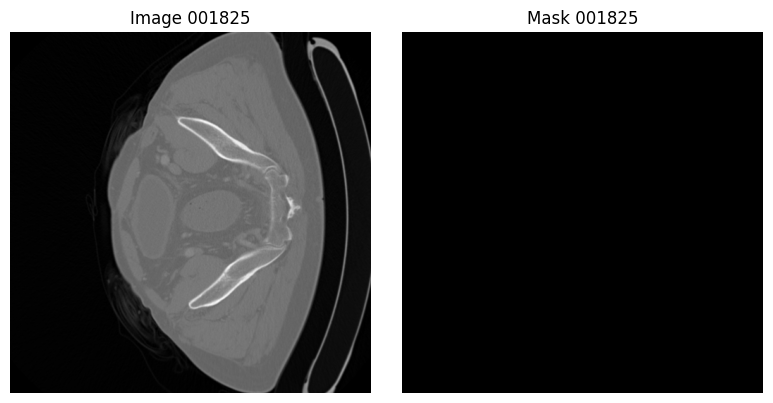

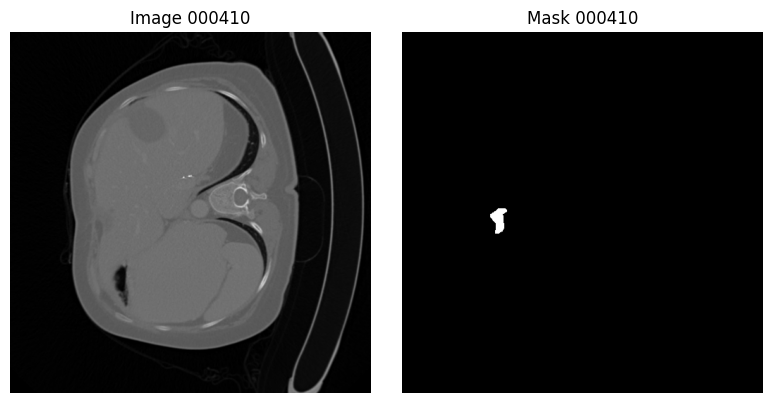

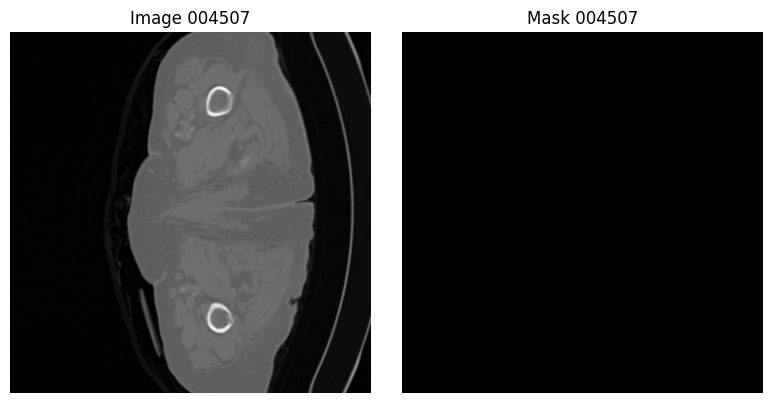

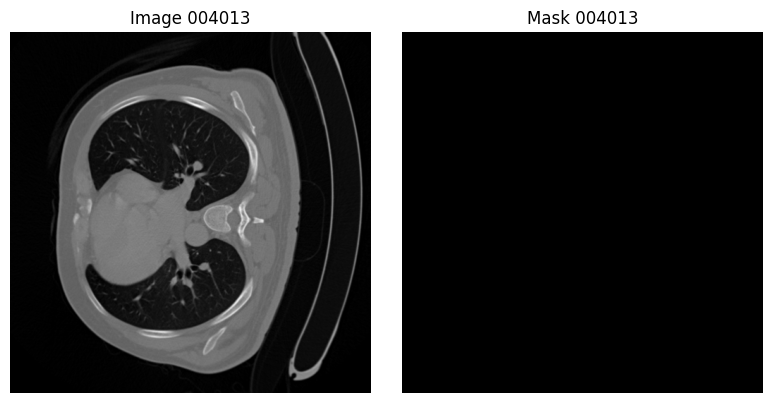

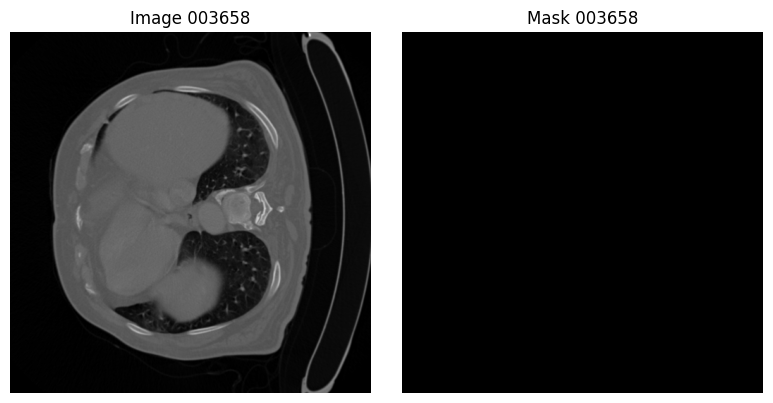

In [ ]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# Set folders
img_dir = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices/images")
msk_dir = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices/masks")

# List all image files (filenames like 000001.png)
all_imgs = sorted(img_dir.glob("*.png"))

# Pick five unique random indices
random.seed(42)                 # optional: makes the selection reproducible
sample_imgs = random.sample(all_imgs, 5)

for img_path in sample_imgs:
    slice_id = img_path.stem          # e.g. "000123"
    mask_path = msk_dir / f"{slice_id}.png"

    # Read the image and mask
    img  = imageio.imread(img_path)
    msk  = imageio.imread(mask_path)

    # Plot side‑by‑side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Image {slice_id}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(msk, cmap="gray")
    plt.title(f"Mask {slice_id}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


###Step6:Unique Intensity Values for First 50 Pairs


In [ ]:
from pathlib import Path
import imageio.v2 as imageio
import numpy as np
import random

# Directories
img_dir = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices/images")
msk_dir = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices/masks")

# Collect and sort image and mask paths
image_files = sorted(img_dir.glob("*.png"))
mask_files  = sorted(msk_dir.glob("*.png"))

# Ensure filenames match
assert [f.name for f in image_files] == [f.name for f in mask_files], "Mismatch in image-mask names"

# Pick 50 random indices
total = len(image_files)
random_indices = random.sample(range(total), min(50, total))

# Loop through selected random pairs
for idx in random_indices:
    img_path = image_files[idx]
    msk_path = mask_files[idx]

    # Load image and mask
    img  = imageio.imread(img_path)
    mask = imageio.imread(msk_path)

    # Print unique intensities
    print(f"{img_path.name} → Image Intensities: {np.unique(img)}, Mask Values: {np.unique(mask)}")


002287.png → Image Intensities: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 23

In [ ]:
from pathlib import Path

# Directories
img_dir = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices/images")
msk_dir = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices/masks")

# Count PNG files
num_images = len(list(img_dir.glob("*.png")))
num_masks  = len(list(msk_dir.glob("*.png")))

print(f"Number of image slices: {num_images}")
print(f"Number of mask slices:  {num_masks}")

# Sanity check
if num_images == num_masks:
    print(" Number of image and mask slices match.")
else:
    print(" Mismatch detected between image and mask slices.")


Number of image slices: 8418
Number of mask slices:  8418
 Number of image and mask slices match.


###Step7:Rotate & Overwrite in Place


In [ ]:
from pathlib import Path
import numpy as np
import imageio.v2 as imageio
from tqdm import tqdm

# Source directories
img_dir = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices/images")
msk_dir = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices/masks")

# Get list of files
image_files = sorted(img_dir.glob("*.png"))
mask_files  = sorted(msk_dir.glob("*.png"))

# Ensure matching names
assert [img.name for img in image_files] == [msk.name for msk in mask_files], "Mismatch in image-mask filenames"

# Rotate each pair and overwrite
for img_path, msk_path in tqdm(zip(image_files, mask_files), total=len(image_files)):
    # Read slices
    img = imageio.imread(img_path)
    msk = imageio.imread(msk_path)

    # Rotate 90° clockwise (abdomen up)
    img_rot = np.rot90(img, k=-1)
    msk_rot = np.rot90(msk, k=-1)

    # Overwrite in place
    imageio.imwrite(img_path, img_rot)
    imageio.imwrite(msk_path, msk_rot)

print(" All slices rotated and saved in place.")


100%|██████████| 8418/8418 [17:33<00:00,  7.99it/s]

 All slices rotated and saved in place.


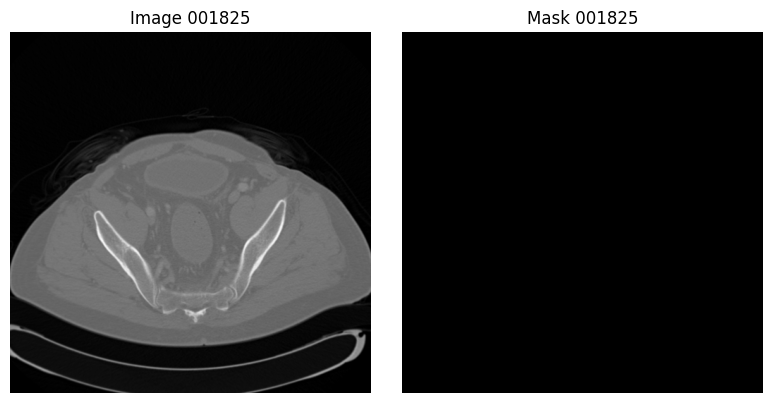

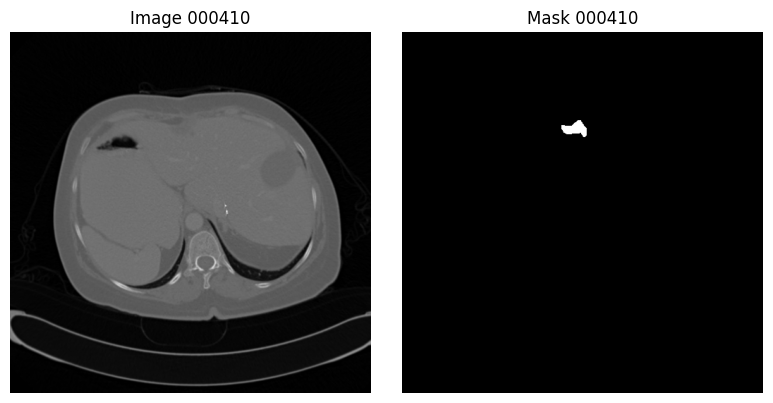

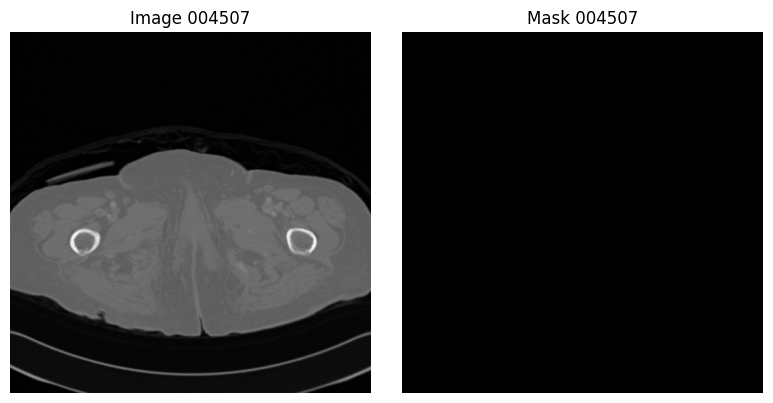

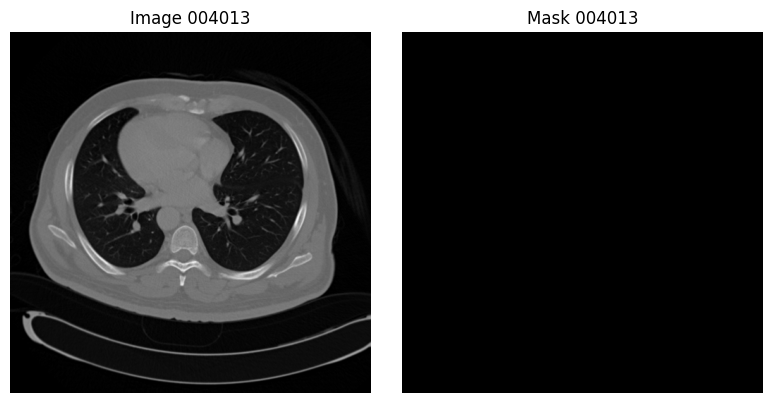

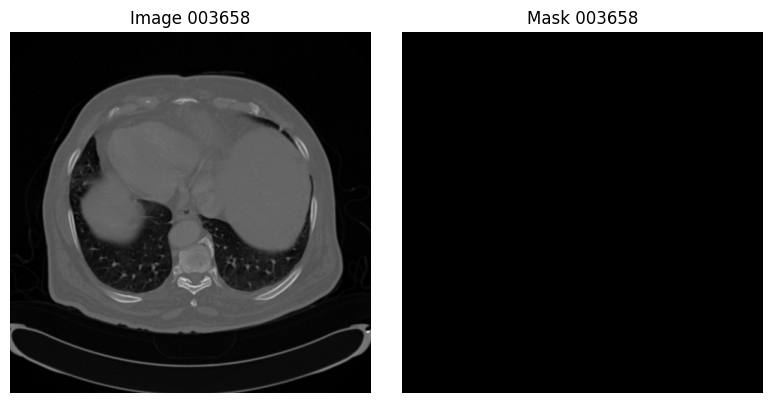

In [ ]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# Set folders
img_dir = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices/images")
msk_dir = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices/masks")

# List all image files (filenames like 000001.png)
all_imgs = sorted(img_dir.glob("*.png"))

# Pick five unique random indices
random.seed(42)                 # optional: makes the selection reproducible
sample_imgs = random.sample(all_imgs, 5)

for img_path in sample_imgs:
    slice_id = img_path.stem          # e.g. "000123"
    mask_path = msk_dir / f"{slice_id}.png"

    # Read the image and mask
    img  = imageio.imread(img_path)
    msk  = imageio.imread(mask_path)

    # Plot side‑by‑side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Image {slice_id}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(msk, cmap="gray")
    plt.title(f"Mask {slice_id}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


###Step8: Filter Tumor‑Containing Slices

In [ ]:
from pathlib import Path
import numpy as np
import imageio.v2 as imageio
import shutil
from tqdm import tqdm

# -------- source directories --------
src_root   = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices")
img_dir    = src_root / "images"
msk_dir    = src_root / "masks"

# -------- destination directories --------
dst_root   = Path("/content/drive/MyDrive/SQU_prepared_data_contain_tumors")
dst_imgdir = dst_root / "images"
dst_mskdir = dst_root / "masks"
dst_imgdir.mkdir(parents=True, exist_ok=True)
dst_mskdir.mkdir(parents=True, exist_ok=True)

# -------- gather & sanity‑check --------
image_files = sorted(img_dir.glob("*.png"))
mask_files  = sorted(msk_dir.glob("*.png"))
assert [i.name for i in image_files] == [m.name for m in mask_files], "Image–mask names differ!"

# -------- iterate & copy only tumor slices --------
tumor_idx = 1
for img_path, msk_path in tqdm(zip(image_files, mask_files), total=len(image_files)):
    mask = imageio.imread(msk_path)

    # Keep slice if mask has ≥1 foreground pixel (value > 0)
    if np.any(mask > 0):
        new_name = f"{tumor_idx:06d}.png"
        shutil.copy2(img_path, dst_imgdir / new_name)
        shutil.copy2(msk_path,  dst_mskdir / new_name)
        tumor_idx += 1

print(f"Saved {tumor_idx-1} tumor‑containing slices to {dst_root}")


100%|██████████| 8418/8418 [03:37<00:00, 38.78it/s]

Saved 1293 tumor‑containing slices to /content/drive/MyDrive/SQU_prepared_data_contain_tumors


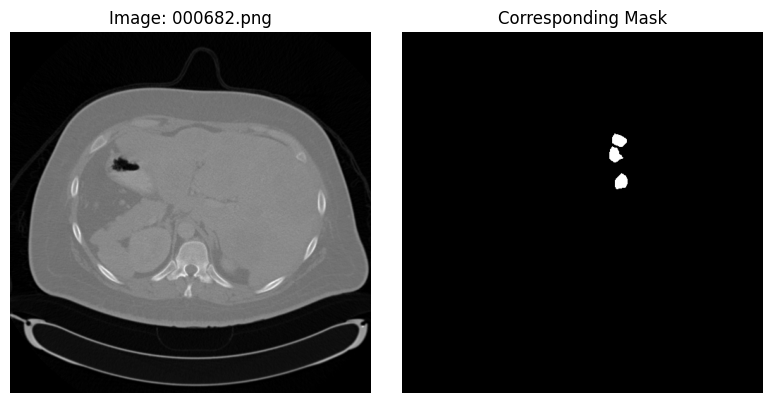

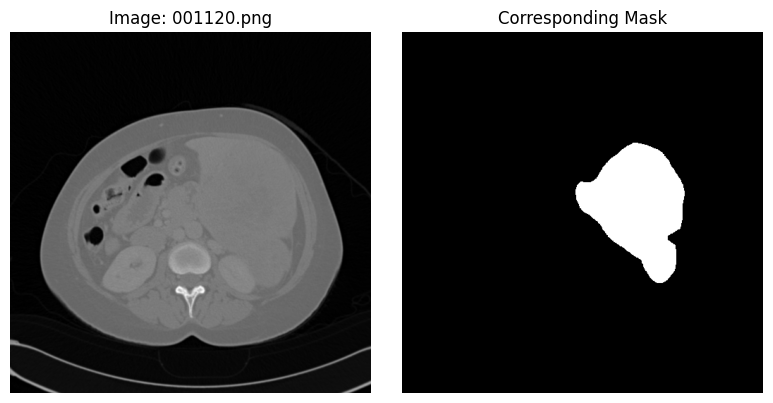

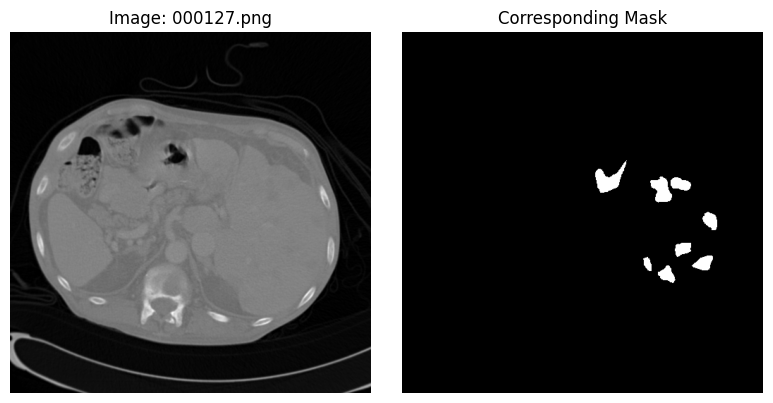

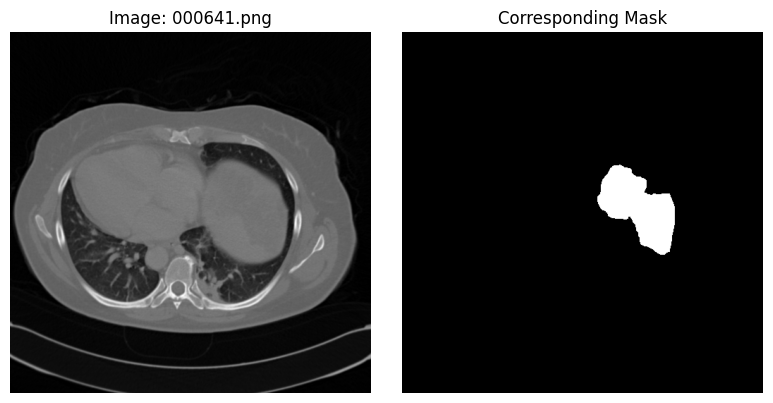

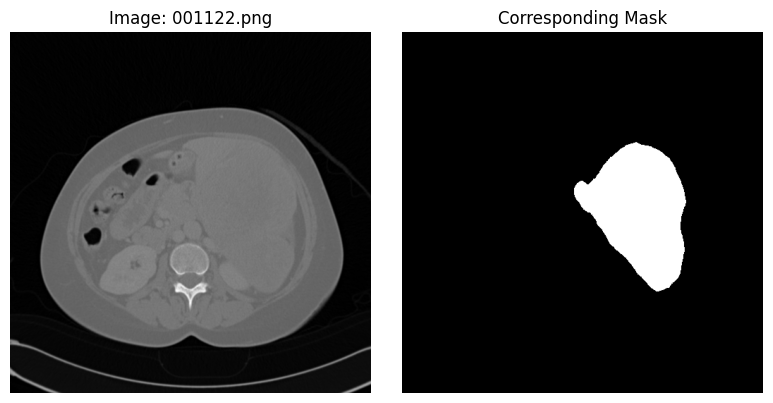

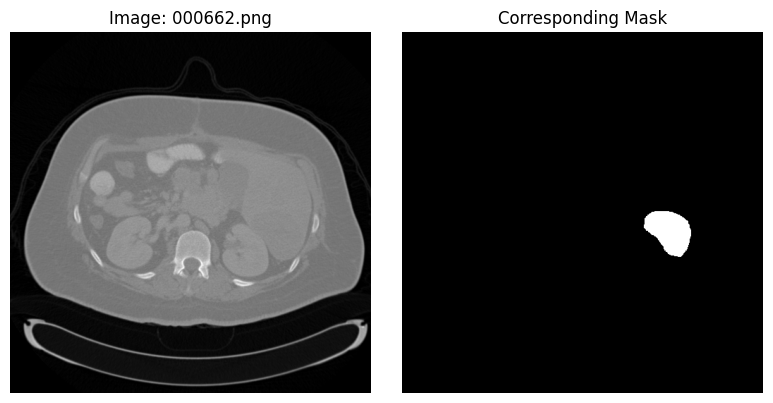

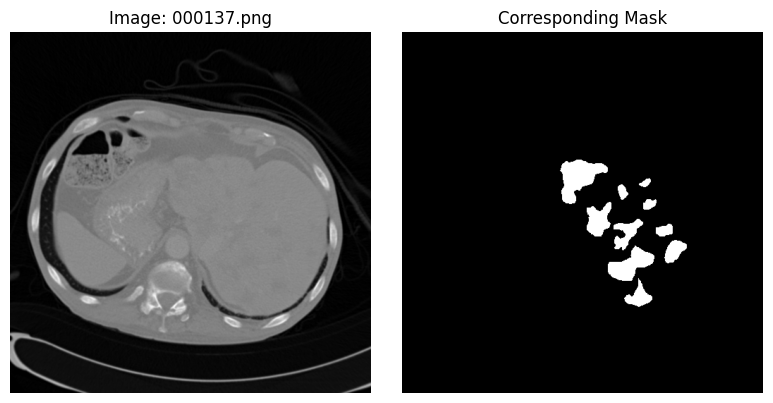

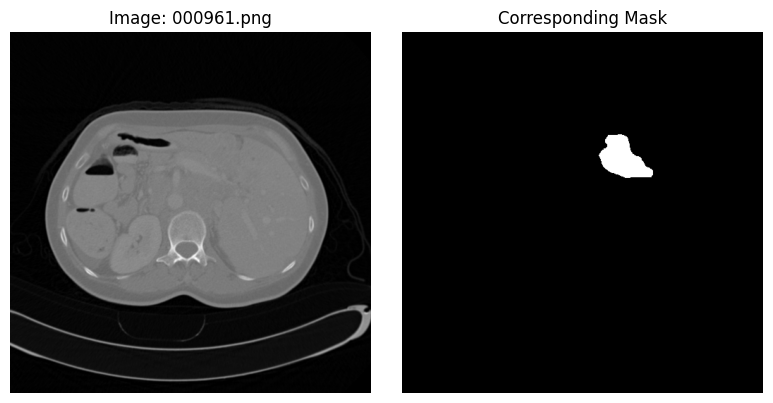

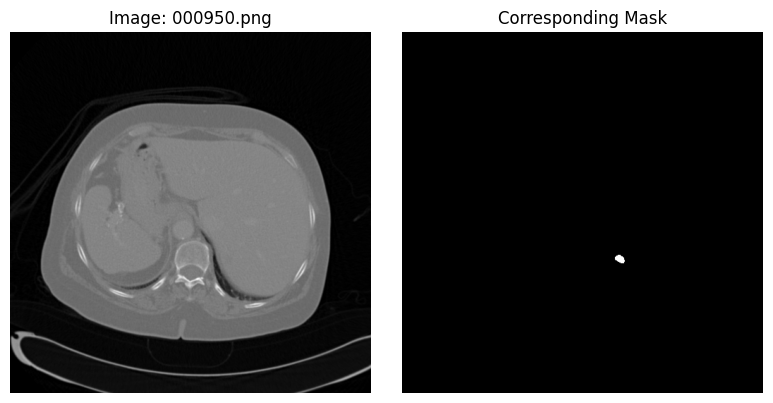

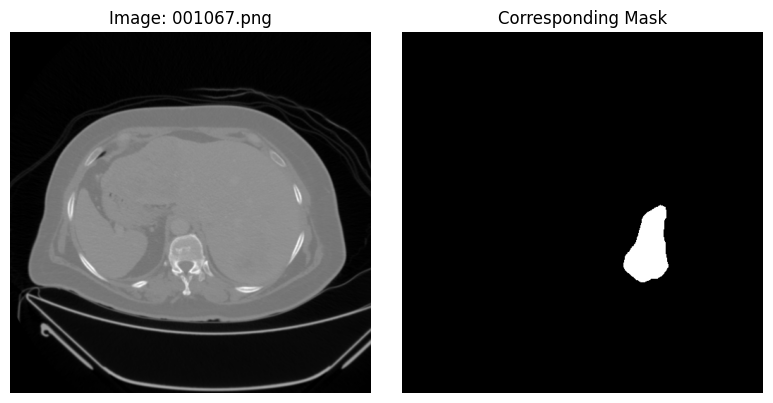

In [ ]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import numpy as np
from pathlib import Path
import random

# Tumor-only dataset directories
img_dir = Path("/content/drive/MyDrive/SQU_prepared_data_contain_tumors/images")
msk_dir = Path("/content/drive/MyDrive/SQU_prepared_data_contain_tumors/masks")

# List all PNG files
image_files = sorted(img_dir.glob("*.png"))
mask_files  = sorted(msk_dir.glob("*.png"))

# Ensure matching filenames
assert [img.name for img in image_files] == [msk.name for msk in mask_files], "Mismatch in image-mask names"

# Pick 10 random indices
sample_files = random.sample(image_files, 10)

# Plot
for img_path in sample_files:
    msk_path = msk_dir / img_path.name
    img = imageio.imread(img_path)
    msk = imageio.imread(msk_path)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image: {img_path.name}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(msk, cmap='gray')
    plt.title("Corresponding Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


###Step9:Horizontally Flip Image–Mask Pairs so liver will be located right in the same anatomical position


In [ ]:
from pathlib import Path
import numpy as np
import imageio.v2 as imageio
from tqdm import tqdm

# Directories
img_dir = Path("/content/drive/MyDrive/SQU_prepared_data_contain_tumors/images")
msk_dir = Path("/content/drive/MyDrive/SQU_prepared_data_contain_tumors/masks")

# Get files
image_files = sorted(img_dir.glob("*.png"))
mask_files  = sorted(msk_dir.glob("*.png"))

# Ensure same filenames
assert [i.name for i in image_files] == [m.name for m in mask_files], "Filenames mismatch!"

# Flip and overwrite
for img_path, msk_path in tqdm(zip(image_files, mask_files), total=len(image_files)):
    img = imageio.imread(img_path)
    msk = imageio.imread(msk_path)

    # Horizontal flip (left-right)
    img_flipped = np.fliplr(img)
    msk_flipped = np.fliplr(msk)

    # Overwrite in-place
    imageio.imwrite(img_path, img_flipped)
    imageio.imwrite(msk_path, msk_flipped)

print(" All image–mask pairs flipped horizontally and saved in-place.")


100%|██████████| 1293/1293 [02:36<00:00,  8.26it/s]

 All image–mask pairs flipped horizontally and saved in-place.


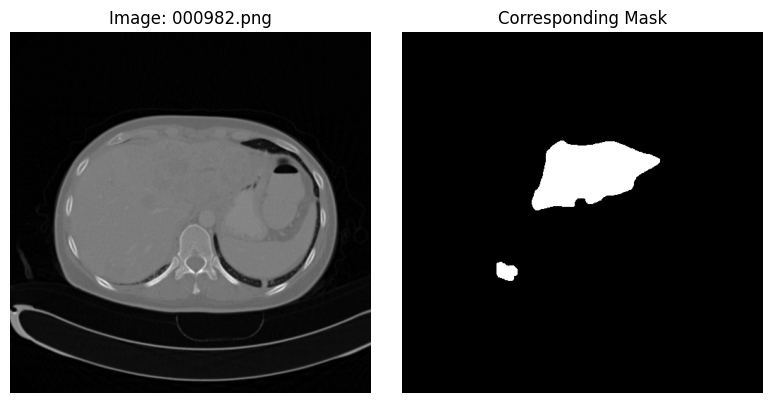

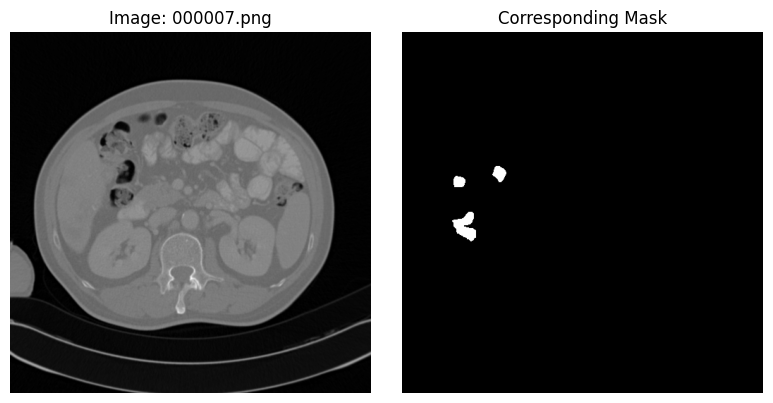

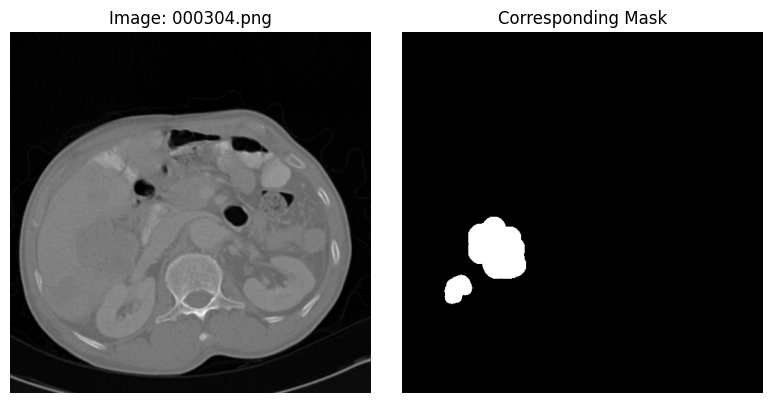

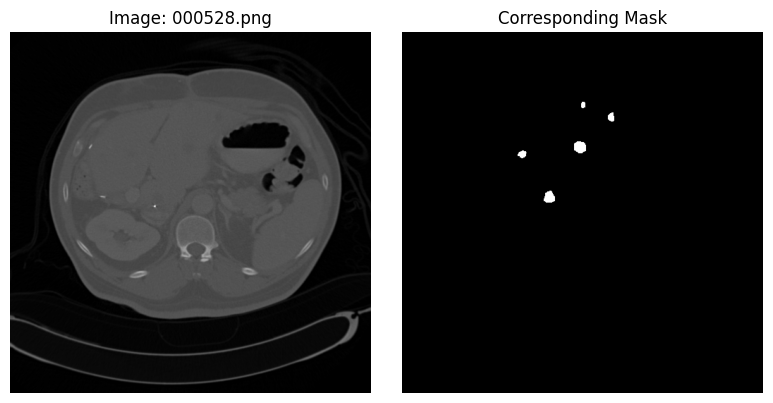

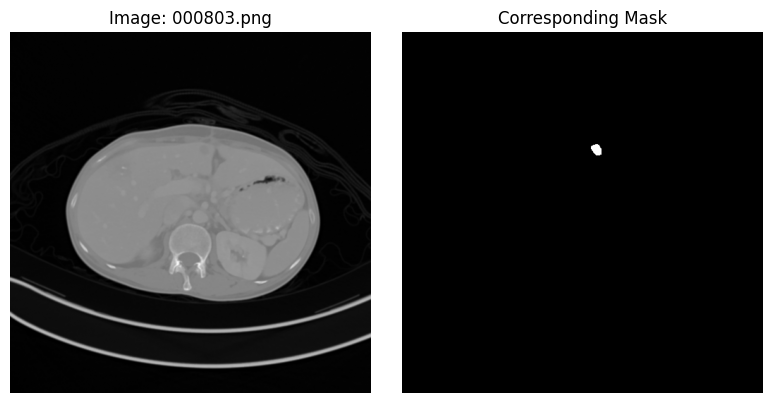

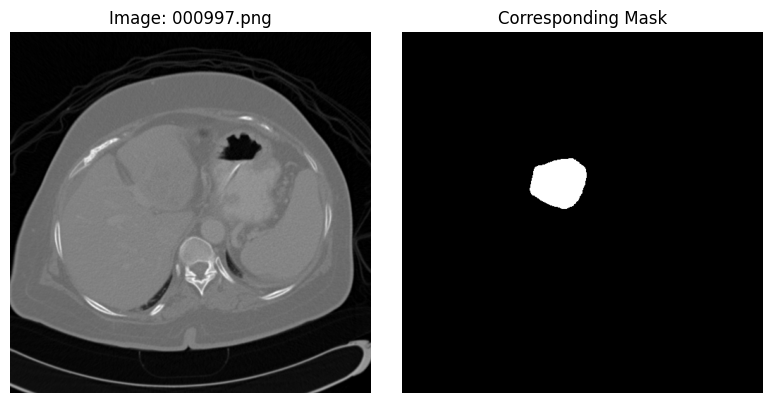

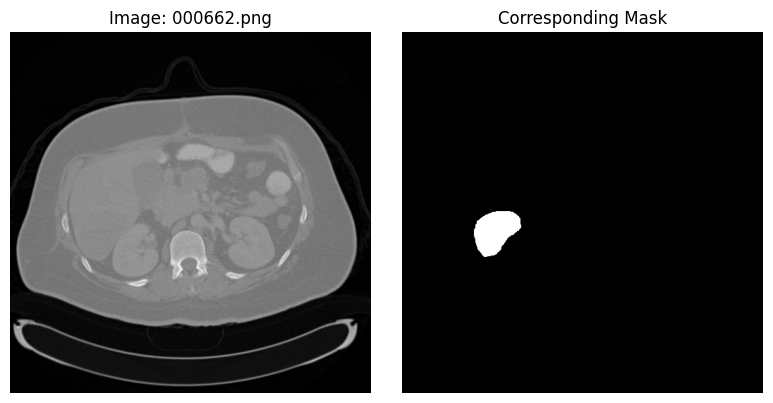

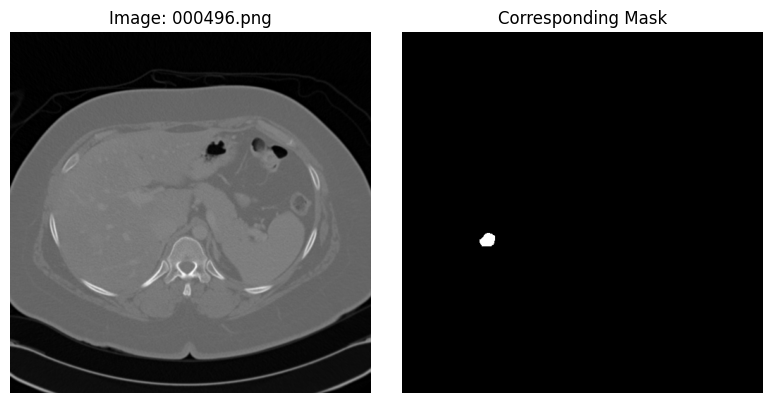

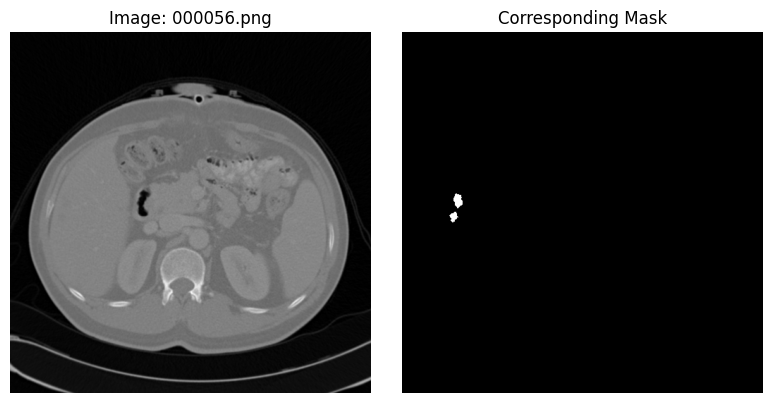

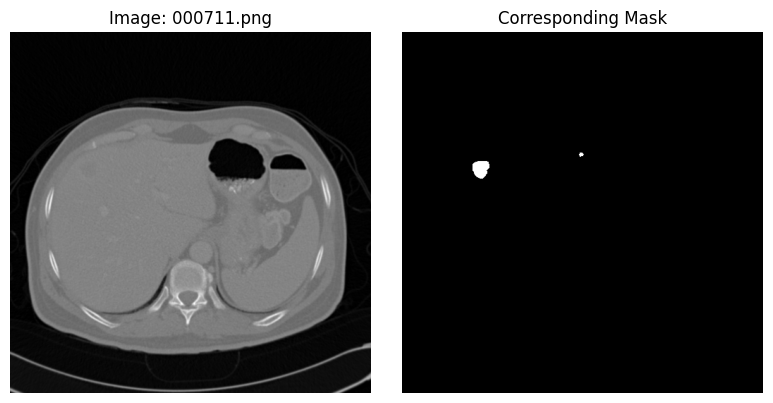

In [ ]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import numpy as np
from pathlib import Path
import random

# Tumor-only dataset directories
img_dir = Path("/content/drive/MyDrive/SQU_prepared_data_contain_tumors/images")
msk_dir = Path("/content/drive/MyDrive/SQU_prepared_data_contain_tumors/masks")

# List all PNG files
image_files = sorted(img_dir.glob("*.png"))
mask_files  = sorted(msk_dir.glob("*.png"))

# Ensure matching filenames
assert [img.name for img in image_files] == [msk.name for msk in mask_files], "Mismatch in image-mask names"

# Pick 10 random indices
sample_files = random.sample(image_files, 10)

# Plot
for img_path in sample_files:
    msk_path = msk_dir / img_path.name
    img = imageio.imread(img_path)
    msk = imageio.imread(msk_path)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image: {img_path.name}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(msk, cmap='gray')
    plt.title("Corresponding Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


#DATA PREPROCESSING

###Step1: Data Splitting

In [ ]:
from pathlib import Path
import shutil, random

# -------- configuration --------
src_root   = Path("/content/drive/MyDrive/SQU_prepared_data_contain_tumors")
dst_root   = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10")
splits     = {"train": 0.80, "val": 0.10, "test": 0.10}
random_seed = 42            # fix for reproducibility
# --------------------------------

def make_dirs(split):
    (dst_root / split / "images").mkdir(parents=True, exist_ok=True)
    (dst_root / split / "masks").mkdir(parents=True, exist_ok=True)

for s in splits:
    make_dirs(s)

# ------- collect & sanity‑check -------
img_files = sorted((src_root / "images").glob("*.png"))
msk_files = sorted((src_root / "masks").glob("*.png"))
assert [i.name for i in img_files] == [m.name for m in msk_files], "Image–mask name mismatch"

paired = list(zip(img_files, msk_files))
random.Random(random_seed).shuffle(paired)

# ------- compute split indices -------
n_total = len(paired)
n_train = int(splits["train"] * n_total)
n_val   = int(splits["val"]   * n_total)

split_ranges = {
    "train": paired[:n_train],
    "val":   paired[n_train : n_train + n_val],
    "test":  paired[n_train + n_val : ]
}

# ------- copy files into split folders -------
for split, pairs in split_ranges.items():
    for img_p, msk_p in pairs:
        out_img = dst_root / split / "images" / img_p.name
        out_msk = dst_root / split / "masks" / msk_p.name
        shutil.copy2(img_p,  out_img)
        shutil.copy2(msk_p,  out_msk)

# ------- summary -------
for split in ["train", "val", "test"]:
    n_img = len(list((dst_root / split / "images").glob("*.png")))
    print(f"{split.capitalize():5s}: {n_img:4d} image–mask pairs")

print(" Random 80/10/10 slice‑level split complete.")


Train: 1034 image–mask pairs
Val  :  129 image–mask pairs
Test :  130 image–mask pairs
 Random 80/10/10 slice‑level split complete.


###Step 2: Randomly Include Non-Tumor Slices in Validation and Test Sets


In [ ]:
from pathlib import Path
import imageio.v2 as imageio
import numpy as np
import random
import shutil

# -------- Source (full dataset) --------
img_dir = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices/images")
msk_dir = Path("/content/drive/MyDrive/SQU_prepared_data__allSlices/masks")

# -------- Destination --------
out_root = Path("/content/drive/MyDrive/SQU_nontumor_samples_20")
out_img  = out_root / "images"
out_msk  = out_root / "masks"
out_img.mkdir(parents=True, exist_ok=True)
out_msk.mkdir(parents=True, exist_ok=True)

# -------- Gather and shuffle --------
image_files = sorted(img_dir.glob("*.png"))
mask_files  = sorted(msk_dir.glob("*.png"))
assert [i.name for i in image_files] == [m.name for m in mask_files], "Image-mask mismatch"

paired = list(zip(image_files, mask_files))
random.shuffle(paired)

# -------- Select non-tumor slices --------
selected = []
for img_path, msk_path in paired:
    mask = imageio.imread(msk_path)
    if np.max(mask) == 0:  # no tumor
        selected.append((img_path, msk_path))
    if len(selected) == 20:
        break

# -------- Copy to destination --------
for i, (img_p, msk_p) in enumerate(selected, start=1):
    new_name = f"{i:05d}.png"
    shutil.copy2(img_p, out_img / new_name)
    shutil.copy2(msk_p, out_msk / new_name)

print(f" Saved {len(selected)} non-tumor image–mask pairs to: {out_root}")


 Saved 20 non-tumor image–mask pairs to: /content/drive/MyDrive/SQU_nontumor_samples_20


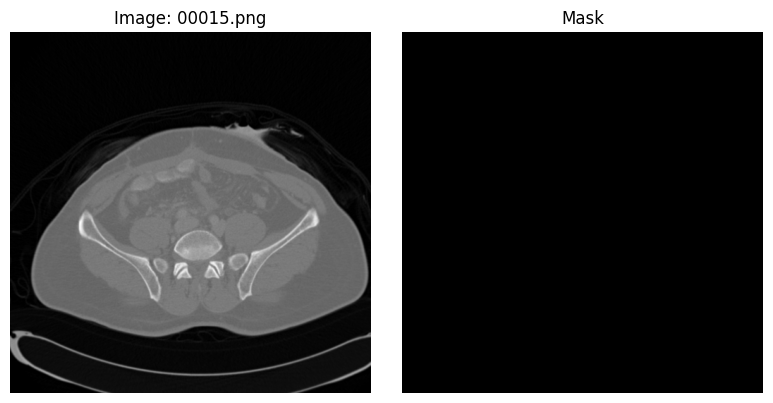

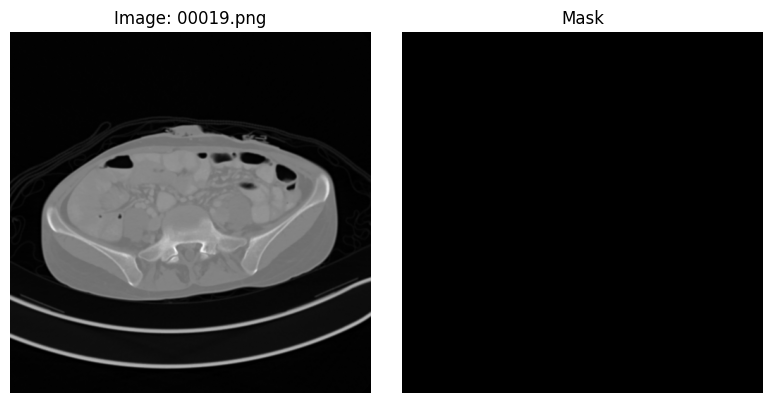

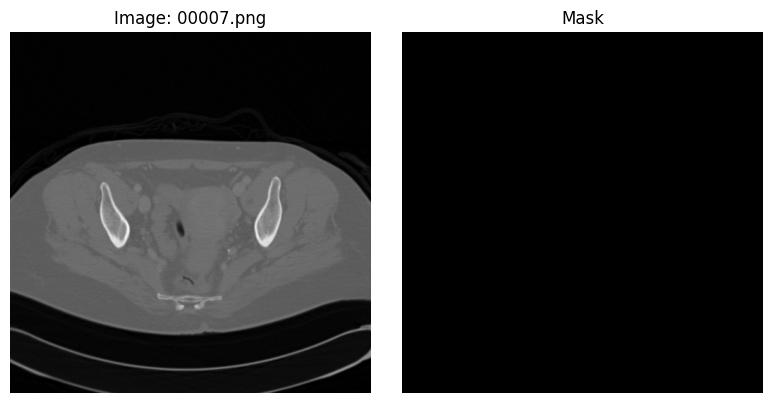

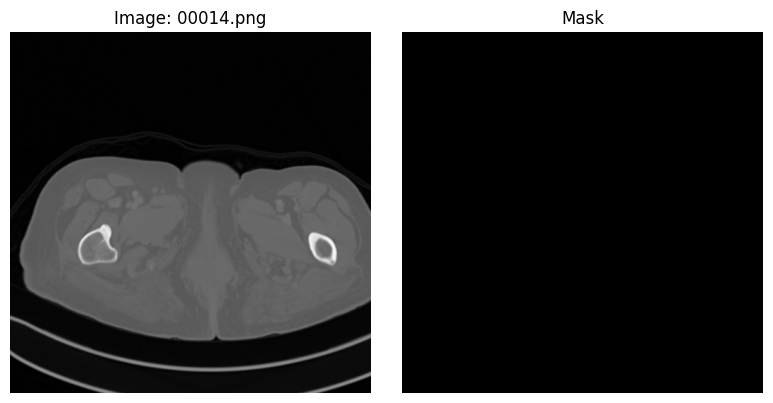

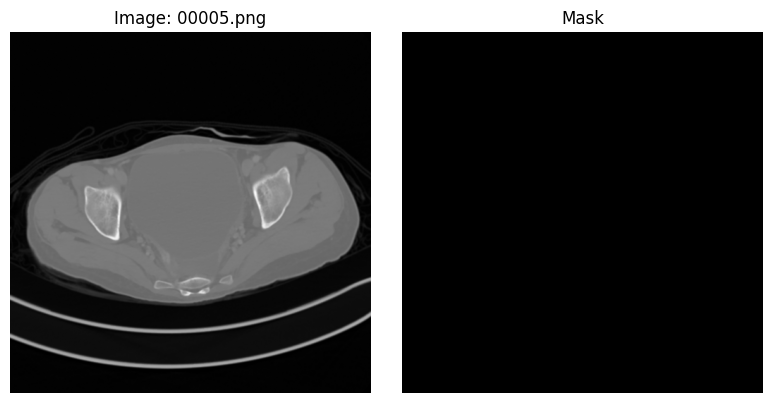

In [ ]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import random
from pathlib import Path

# Folder with non-tumor samples
img_dir = Path("/content/drive/MyDrive/SQU_nontumor_samples_20/images")
msk_dir = Path("/content/drive/MyDrive/SQU_nontumor_samples_20/masks")

# Get all filenames
image_files = sorted(img_dir.glob("*.png"))
mask_files  = sorted(msk_dir.glob("*.png"))

# Ensure matched filenames
assert [i.name for i in image_files] == [m.name for m in mask_files], "Mismatch in image-mask pairs"

# Pick 5 random pairs
samples = random.sample(image_files, 5)

# Plot
for img_path in samples:
    msk_path = msk_dir / img_path.name
    img = imageio.imread(img_path)
    msk = imageio.imread(msk_path)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image: {img_path.name}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(msk, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
from pathlib import Path
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm

# Folder with non-tumor samples
img_dir = Path("/content/drive/MyDrive/SQU_nontumor_samples_20/images")
msk_dir = Path("/content/drive/MyDrive/SQU_nontumor_samples_20/masks")

# Get matching files
image_files = sorted(img_dir.glob("*.png"))
mask_files  = sorted(msk_dir.glob("*.png"))

# Ensure filenames match
assert [i.name for i in image_files] == [m.name for m in mask_files], "Mismatch in image-mask pairs"

# Flip each pair
for img_path, msk_path in tqdm(zip(image_files, mask_files), total=len(image_files)):
    img = imageio.imread(img_path)
    msk = imageio.imread(msk_path)

    img_flipped = np.fliplr(img)
    msk_flipped = np.fliplr(msk)

    imageio.imwrite(img_path, img_flipped)
    imageio.imwrite(msk_path, msk_flipped)

print(" All non-tumor pairs horizontally flipped in-place.")


100%|██████████| 20/20 [00:02<00:00,  9.34it/s]

 All non-tumor pairs horizontally flipped in-place.


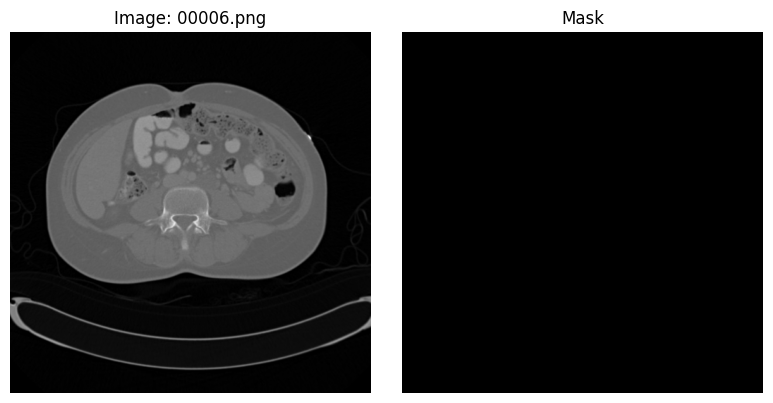

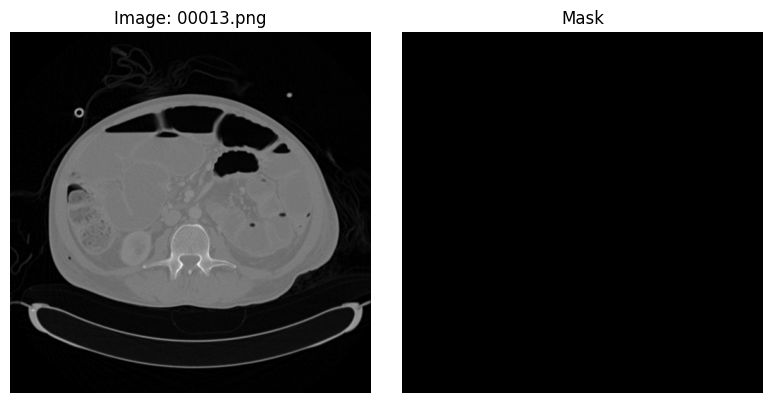

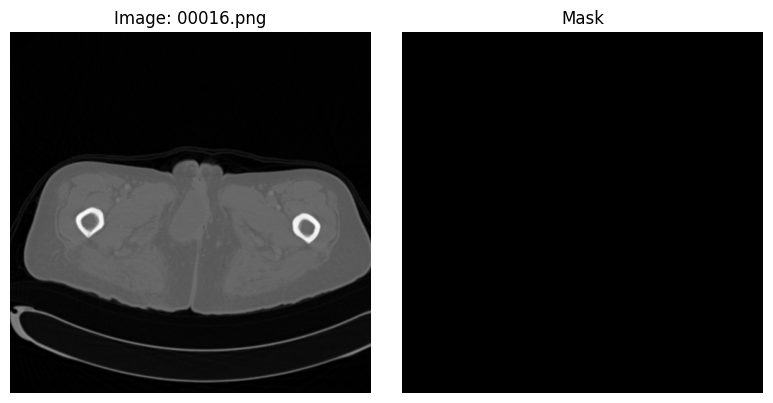

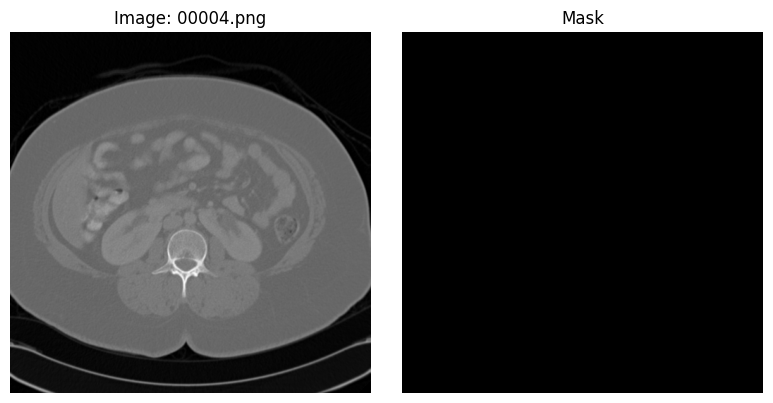

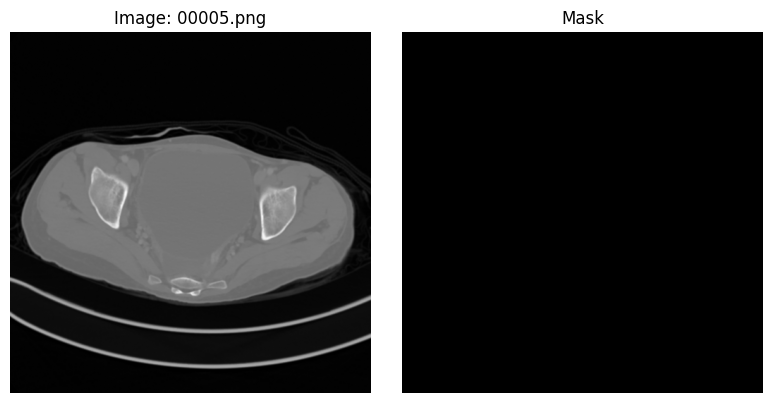

In [ ]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import random
from pathlib import Path

# Folder with non-tumor samples
img_dir = Path("/content/drive/MyDrive/SQU_nontumor_samples_20/images")
msk_dir = Path("/content/drive/MyDrive/SQU_nontumor_samples_20/masks")

# Get all filenames
image_files = sorted(img_dir.glob("*.png"))
mask_files  = sorted(msk_dir.glob("*.png"))

# Ensure matched filenames
assert [i.name for i in image_files] == [m.name for m in mask_files], "Mismatch in image-mask pairs"

# Pick 5 random pairs
samples = random.sample(image_files, 5)

# Plot
for img_path in samples:
    msk_path = msk_dir / img_path.name
    img = imageio.imread(img_path)
    msk = imageio.imread(msk_path)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image: {img_path.name}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(msk, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


###ٍStep3 : include non tumor image mask pairs in test and valid sets

In [ ]:
from pathlib import Path
import shutil, random, imageio.v2 as imageio, numpy as np

# ------------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------------
split_root   = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10")
neg_root     = Path("/content/drive/MyDrive/SQU_nontumor_samples_20")  # non‑tumour pairs
neg_to_val   = 10       # how many negative pairs to add to val
neg_to_test  = 10       # how many negative pairs to add to test
digits       = 4        # zero‑padded width for new filenames (0001, 0002, …)
random_seed  = 42
# ------------------------------------------------------------------

random.seed(random_seed)

# ------------------------------------------------------------------
# 1) pick 20 random negative pairs and MOVE them
# ------------------------------------------------------------------
neg_imgs = sorted((neg_root / "images").glob("*.png"))
neg_msks = sorted((neg_root / "masks").glob("*.png"))
assert [p.name for p in neg_imgs] == [p.name for p in neg_msks], "non‑tumour filenames mismatch"

pairs = list(zip(neg_imgs, neg_msks))
random.shuffle(pairs)

destinations = (
    ("val",  neg_to_val),
    ("test", neg_to_test),
)
for split_name, how_many in destinations:
    dest_img = split_root / split_name / "images"
    dest_msk = split_root / split_name / "masks"
    dest_img.mkdir(parents=True, exist_ok=True)
    dest_msk.mkdir(parents=True, exist_ok=True)

    selected = pairs[:how_many]
    del pairs[:how_many]

    for img_p, msk_p in selected:
        shutil.move(img_p, dest_img / img_p.name)
        shutil.move(msk_p, dest_msk / msk_p.name)

# ------------------------------------------------------------------
# 2) rename files inside each split to 0001.png, 0002.png, ...
# ------------------------------------------------------------------
def reindex_split(split_dir: Path, width: int = 4):
    img_dir = split_dir / "images"
    msk_dir = split_dir / "masks"

    imgs = sorted(img_dir.glob("*.png"))
    msks = sorted(msk_dir.glob("*.png"))
    assert [i.name for i in imgs] == [m.name for m in msks], f"Mismatch in {split_dir.name}"

    for idx, (img_p, msk_p) in enumerate(zip(imgs, msks), start=1):
        new_name = f"{idx:0{width}d}.png"
        img_p.rename(img_dir / new_name)
        msk_p.rename(msk_dir / new_name)

for split_name in ["train", "val", "test"]:
    reindex_split(split_root / split_name, width=digits)

# ------------------------------------------------------------------
# 3) summary
# ------------------------------------------------------------------
for split in ["train", "val", "test"]:
    n_imgs = len(list((split_root / split / "images").glob("*.png")))
    print(f"{split.capitalize():5s}: {n_imgs} image–mask pairs (renamed 0001…)")
print("Done.")


Train: 1034 image–mask pairs (renamed 0001…)
Val  : 139 image–mask pairs (renamed 0001…)
Test : 140 image–mask pairs (renamed 0001…)
Done.


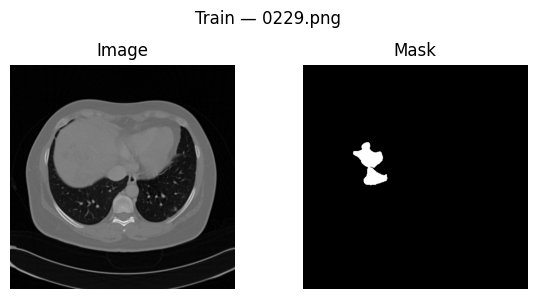

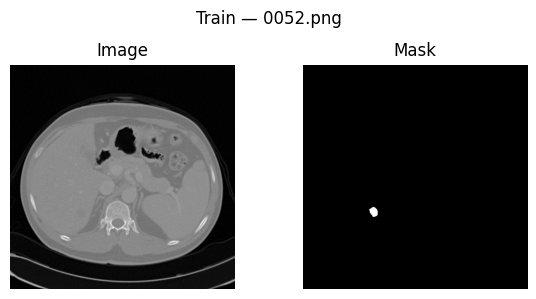

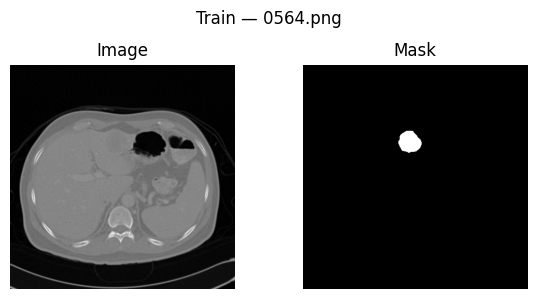

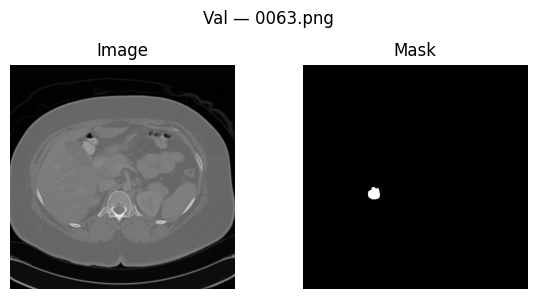

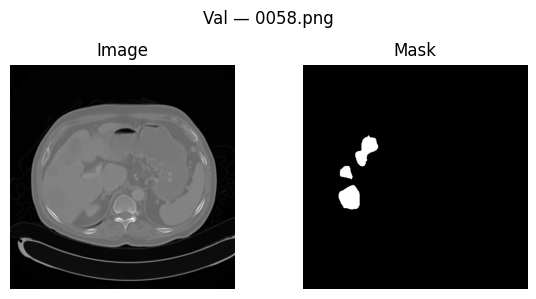

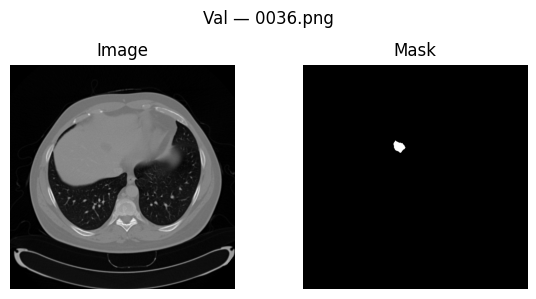

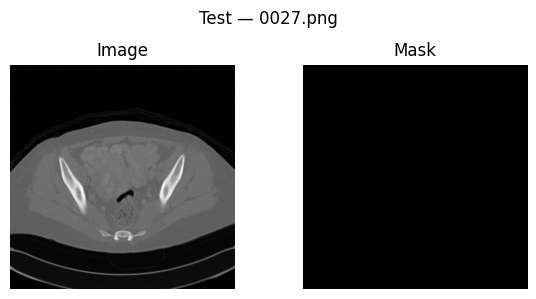

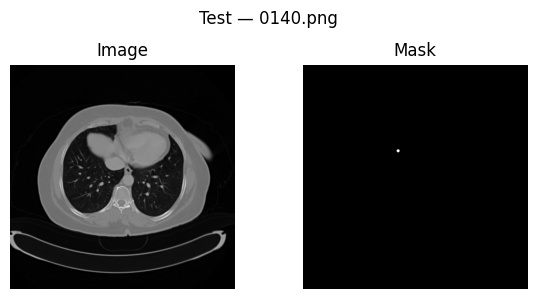

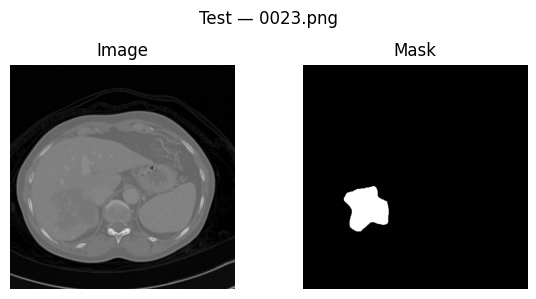

In [ ]:
#sanity check

# ------------------------------------------------------------------
split_root = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10")
splits = ["train", "val", "test"]
random.seed(42)                     # reproducible sampling
# ------------------------------------------------------------------

for split in splits:
    img_dir = split_root / split / "images"
    msk_dir = split_root / split / "masks"

    imgs = sorted(img_dir.glob("*.png"))
    msks = sorted(msk_dir.glob("*.png"))
    assert [i.name for i in imgs] == [m.name for m in msks], f"Mismatch in {split}"

    sample_imgs = random.sample(imgs, min(3, len(imgs)))

    for img_path in sample_imgs:
        msk_path = msk_dir / img_path.name
        img = imageio.imread(img_path)
        msk = imageio.imread(msk_path)

        plt.figure(figsize=(6, 3))
        plt.suptitle(f"{split.capitalize()} — {img_path.name}", fontsize=12)

        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(msk, cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()


###Step4:Data Augmentation on training set(Horizental flipping+translation+elastic deformation)

In [ ]:
import os, cv2, numpy as np, albumentations as A
from pathlib import Path
from tqdm import tqdm

# ------------------------------------------------------------------
# 1) PATHS
# ------------------------------------------------------------------
root      = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10")
img_dir   = root / "train" / "images"
msk_dir   = root / "train" / "masks"

out_img   = root / "train_aug_with_hflip" / "images"
out_msk   = root / "train_aug_with_hflip" / "masks"
out_img.mkdir(parents=True, exist_ok=True)
out_msk.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------------
# 2) AUGMENTATION PIPELINE
# ------------------------------------------------------------------
elastic = A.ElasticTransform(alpha=50, sigma=6, p=1.0)
translate = A.Affine(
    translate_px={"x": (-10, 10), "y": (-10, 10)},
    scale=1.0, rotate=0, p=1.0,
    border_mode=cv2.BORDER_REFLECT
)
flip = A.HorizontalFlip(p=1.0)

# ------------------------------------------------------------------
# 3) PROCESS ALL TRAIN IMAGES
# ------------------------------------------------------------------
for filename in tqdm(sorted(os.listdir(img_dir))):
    img_path  = img_dir / filename
    msk_path  = msk_dir / filename

    # Load grayscale image and mask
    img  = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    msk  = cv2.imread(str(msk_path), cv2.IMREAD_GRAYSCALE)

    msk  = (msk > 0).astype(np.uint8)

    # Albumentations requires HWC format
    img  = img[..., None]
    msk  = msk[..., None]

    # ---- Save Original ----
    cv2.imwrite(str(out_img / filename), img.squeeze())
    cv2.imwrite(str(out_msk / filename), (msk.squeeze() * 255))

    # ---- Elastic ----
    aug = elastic(image=img, mask=msk)
    cv2.imwrite(str(out_img / filename.replace(".png", "_elastic.png")),
                aug["image"].squeeze())
    cv2.imwrite(str(out_msk / filename.replace(".png", "_elastic.png")),
                aug["mask"].squeeze() * 255)

    # ---- Translation ----
    aug = translate(image=img, mask=msk)
    cv2.imwrite(str(out_img / filename.replace(".png", "_trans.png")),
                aug["image"].squeeze())
    cv2.imwrite(str(out_msk / filename.replace(".png", "_trans.png")),
                aug["mask"].squeeze() * 255)

    # ---- Horizontal Flip ----
    aug = flip(image=img, mask=msk)
    cv2.imwrite(str(out_img / filename.replace(".png", "_hflip.png")),
                aug["image"].squeeze())
    cv2.imwrite(str(out_msk / filename.replace(".png", "_hflip.png")),
                aug["mask"].squeeze() * 255)

print("All original + augmented (elastic, translation, hflip) saved to: train_aug_with_hflip/")


100%|██████████| 1034/1034 [03:21<00:00,  5.13it/s]

All original + augmented (elastic, translation, hflip) saved to: train_aug_with_hflip/


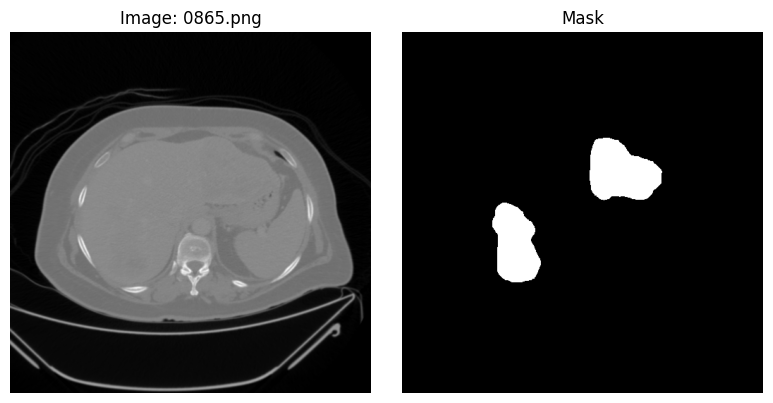

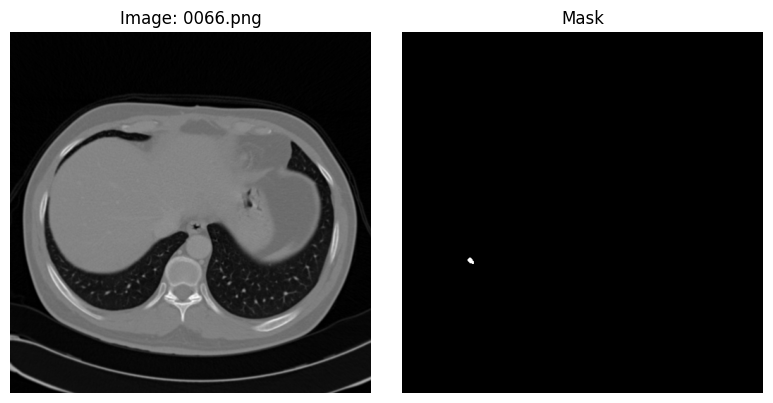

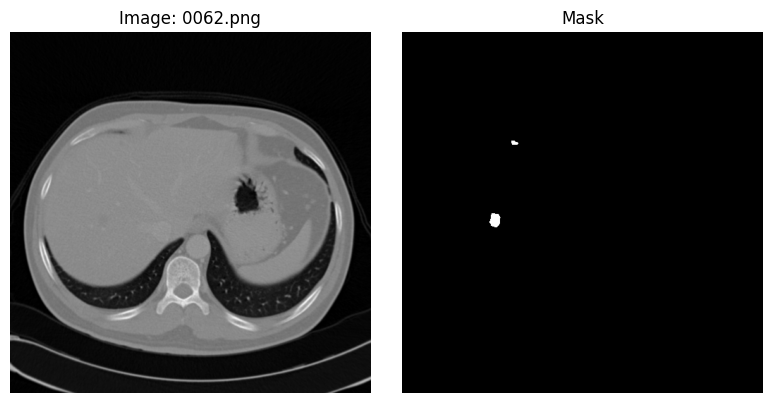

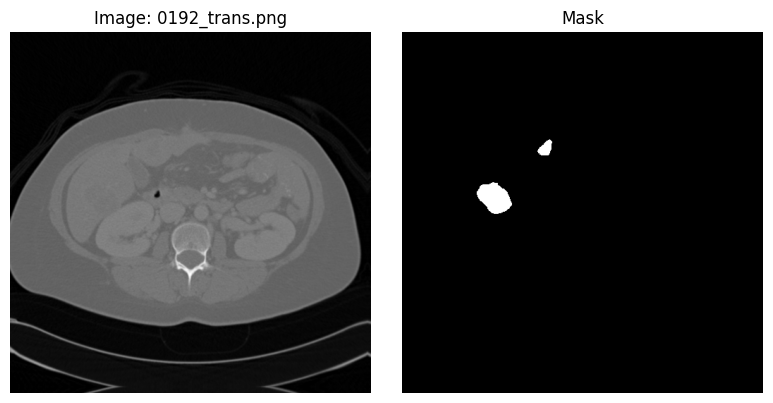

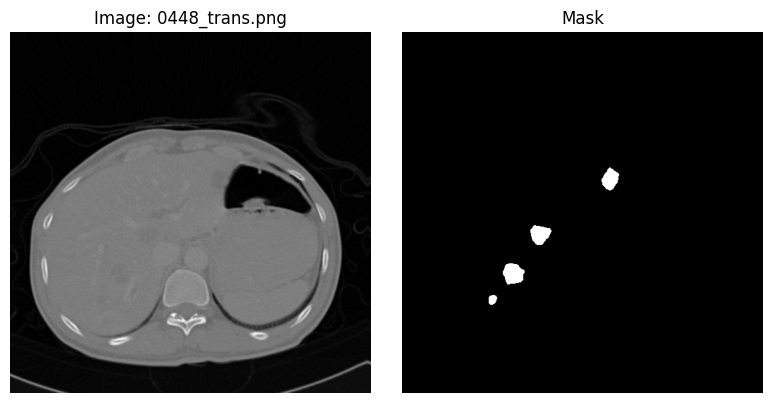

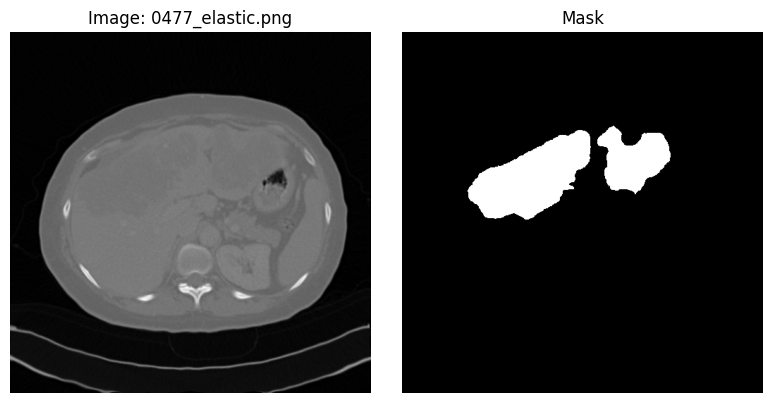

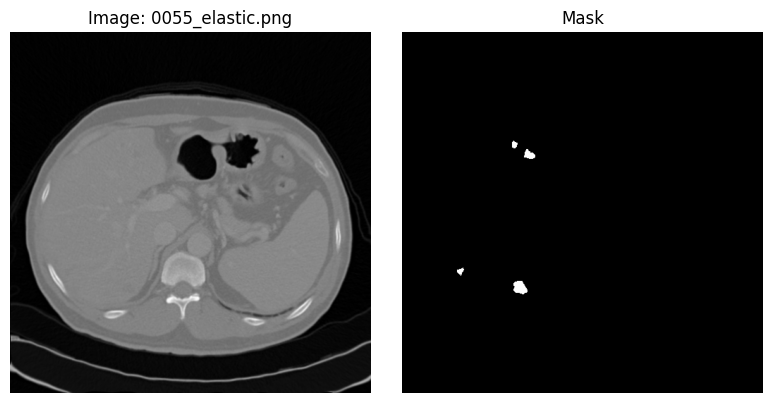

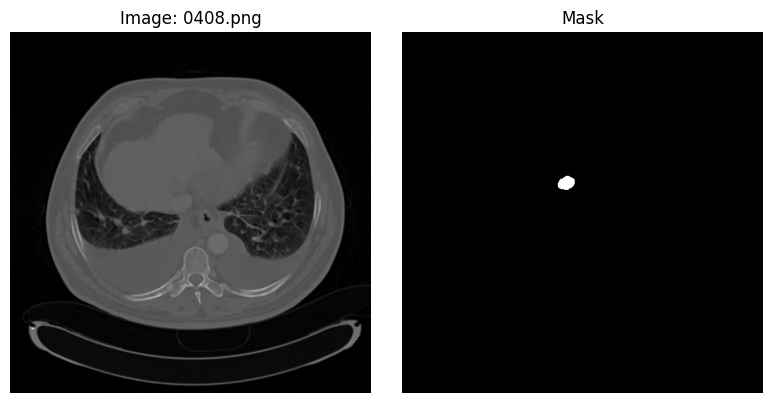

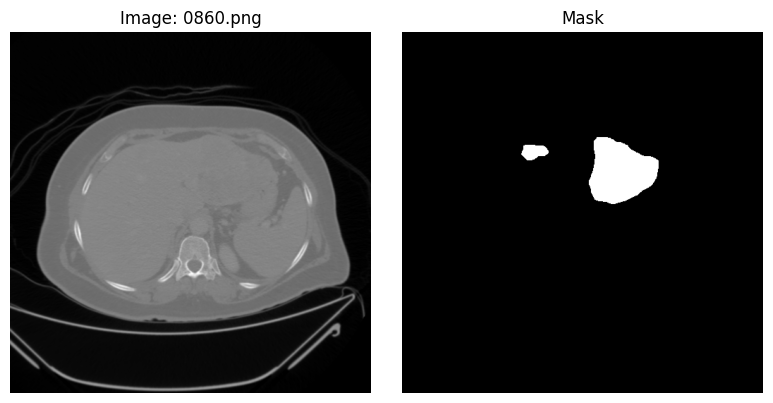

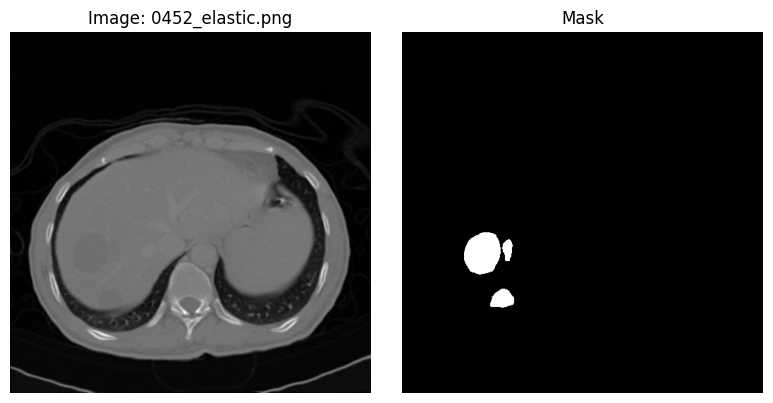

In [ ]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from pathlib import Path
import random

# Set path to your augmented training set
img_dir = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10/train_aug_with_hflip/images")
msk_dir = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10/train_aug_with_hflip/masks")

# Load file lists
image_files = sorted(list(img_dir.glob("*.png")))
mask_files  = sorted(list(msk_dir.glob("*.png")))

# Ensure matching filenames
assert [f.name for f in image_files] == [f.name for f in mask_files], "Mismatch in image/mask filenames"

# Pick 10 random samples
sample_paths = random.sample(image_files, 10)

# Plot each pair
for img_path in sample_paths:
    mask_path = msk_dir / img_path.name
    img  = imageio.imread(img_path)
    mask = imageio.imread(mask_path)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Image: {img_path.name}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
from pathlib import Path

# Paths to image folders
original_img_dir = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10/train/images")
augmented_img_dir = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10/train_aug_with_hflip/images")

# Count PNG files
n_original = len(list(original_img_dir.glob("*.png")))
n_augmented = len(list(augmented_img_dir.glob("*.png")))

# Print results
print(f"Original training pairs: {n_original}")
print(f"Training pairs after augmentation with hflip: {n_augmented}")
print(f"× Augmentation factor: {n_augmented // n_original}")


Original training pairs: 1034
Training pairs after augmentation with hflip: 4136
× Augmentation factor: 4


###Step 5:Data Augmentation on training set(translation+elastic deformation)

In [ ]:
import os, cv2, numpy as np, albumentations as A
from pathlib import Path
from tqdm import tqdm

# ------------------------------------------------------------------
# 1) PATHS
# ------------------------------------------------------------------
root      = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10")
img_dir   = root / "train" / "images"
msk_dir   = root / "train" / "masks"

out_img   = root / "train_aug_nohflip" / "images"
out_msk   = root / "train_aug_nohflip" / "masks"
out_img.mkdir(parents=True, exist_ok=True)
out_msk.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------------
# 2) AUGMENTATION PIPELINE (NO FLIP)
# ------------------------------------------------------------------
elastic = A.ElasticTransform(alpha=50, sigma=6, p=1.0)
translate = A.Affine(
    translate_px={"x": (-10, 10), "y": (-10, 10)},
    scale=1.0, rotate=0, p=1.0,
    border_mode=cv2.BORDER_REFLECT
)

# ------------------------------------------------------------------
# 3) PROCESS ALL TRAIN IMAGES
# ------------------------------------------------------------------
for filename in tqdm(sorted(os.listdir(img_dir))):
    img_path  = img_dir / filename
    msk_path  = msk_dir / filename

    # Load grayscale image and mask
    img  = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    msk  = cv2.imread(str(msk_path), cv2.IMREAD_GRAYSCALE)

    msk  = (msk > 0).astype(np.uint8)
    img  = img[..., None]
    msk  = msk[..., None]

    # ---- Save Original ----
    cv2.imwrite(str(out_img / filename), img.squeeze())
    cv2.imwrite(str(out_msk / filename), (msk.squeeze() * 255))

    # ---- Elastic ----
    aug = elastic(image=img, mask=msk)
    cv2.imwrite(str(out_img / filename.replace(".png", "_elastic.png")),
                aug["image"].squeeze())
    cv2.imwrite(str(out_msk / filename.replace(".png", "_elastic.png")),
                aug["mask"].squeeze() * 255)

    # ---- Translation ----
    aug = translate(image=img, mask=msk)
    cv2.imwrite(str(out_img / filename.replace(".png", "_trans.png")),
                aug["image"].squeeze())
    cv2.imwrite(str(out_msk / filename.replace(".png", "_trans.png")),
                aug["mask"].squeeze() * 255)

print(" Augmented dataset (no horizontal flip) saved to: train_aug_nohflip/")


100%|██████████| 1034/1034 [02:42<00:00,  6.35it/s]

 Augmented dataset (no horizontal flip) saved to: train_aug_nohflip/


In [ ]:
from pathlib import Path

# Original and new augmented folders
orig_img_dir = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10/train/images")
aug_img_dir  = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10/train_aug_nohflip/images")

# Count files
n_orig = len(list(orig_img_dir.glob("*.png")))
n_aug  = len(list(aug_img_dir.glob("*.png")))

print(f"Original training images: {n_orig}")
print(f"Training images after augmentation (no hflip): {n_aug}")
print(f"Augmentation factor: {n_aug // n_orig}")


Original training images: 1034
Training images after augmentation (no hflip): 3102
Augmentation factor: 3


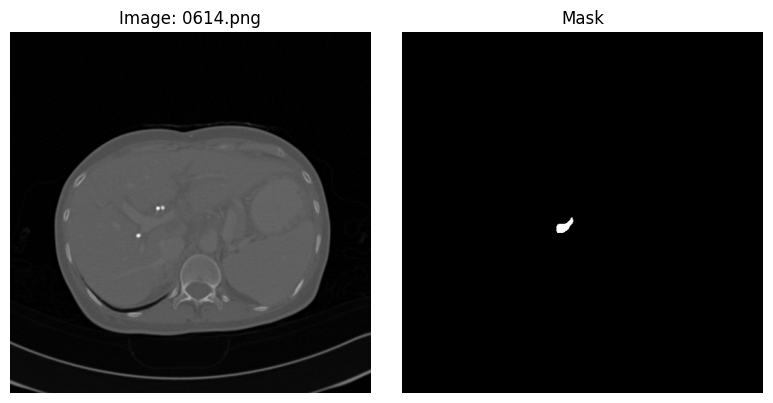

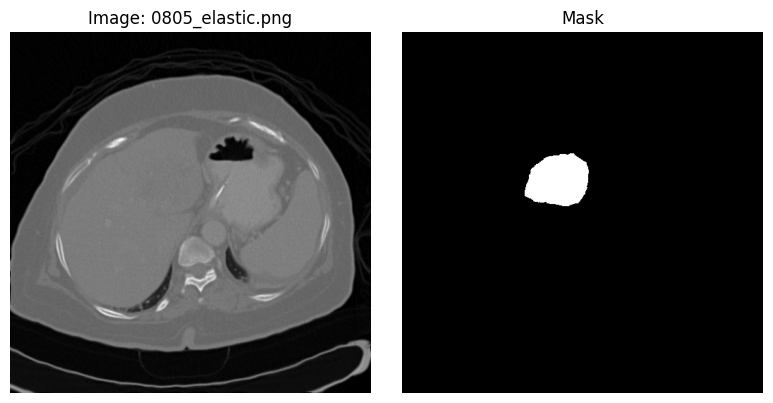

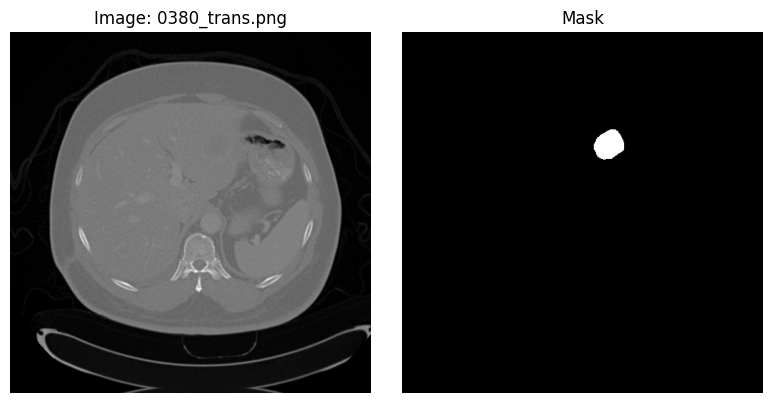

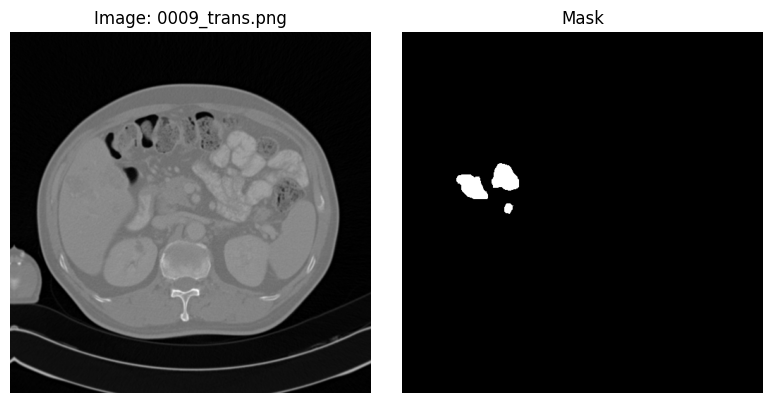

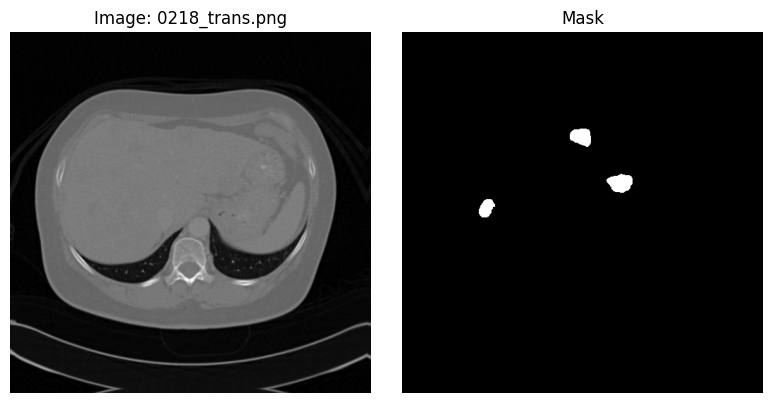

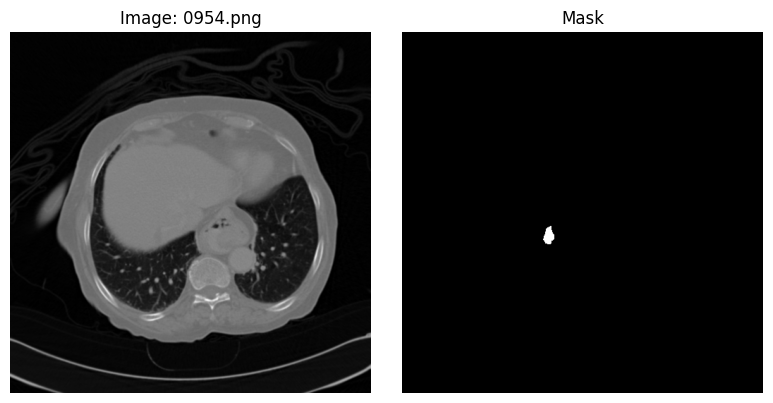

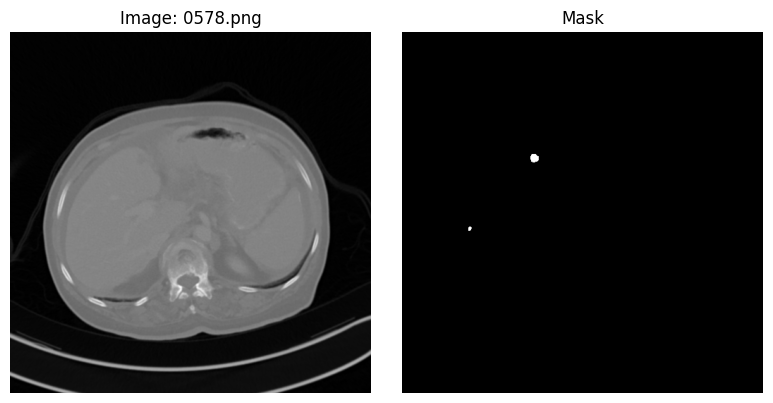

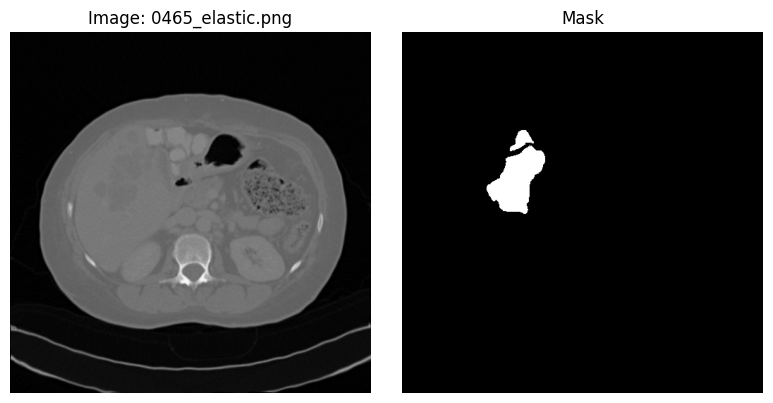

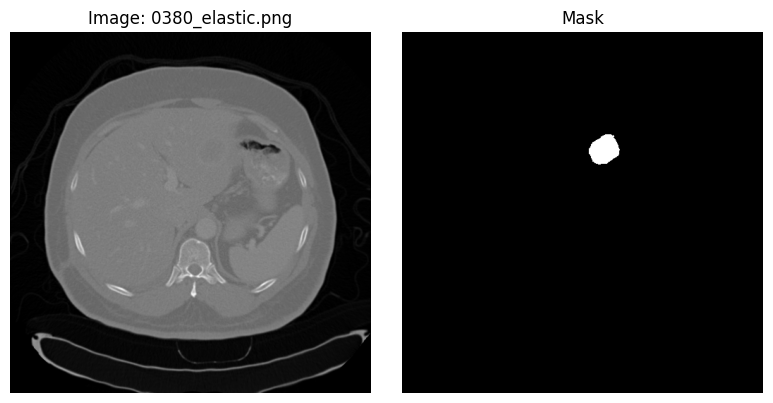

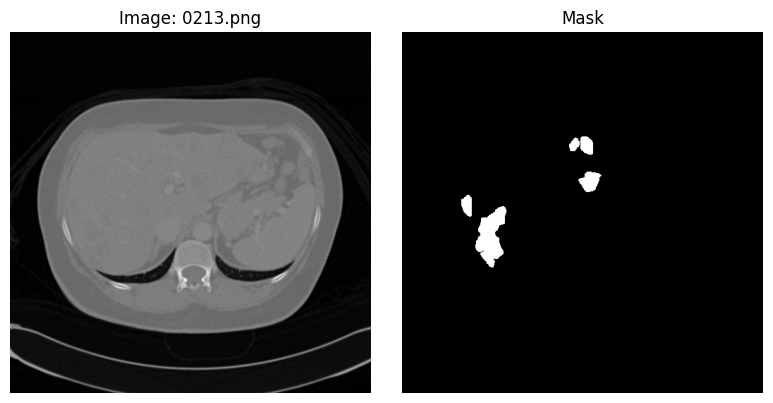

In [ ]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import random

# Directories for augmented images and masks
img_dir = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10/train_aug_nohflip/images")
msk_dir = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10/train_aug_nohflip/masks")

# Get all .png files
image_files = sorted(list(img_dir.glob("*.png")))
mask_files  = sorted(list(msk_dir.glob("*.png")))

# Make sure all pairs match
assert [img.name for img in image_files] == [msk.name for msk in mask_files], "Mismatch in image-mask filenames"

# Pick 10 random image paths
sample_paths = random.sample(image_files, 10)

# Plot
for img_path in sample_paths:
    mask_path = msk_dir / img_path.name
    img  = imageio.imread(img_path)
    mask = imageio.imread(mask_path)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image: {img_path.name}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


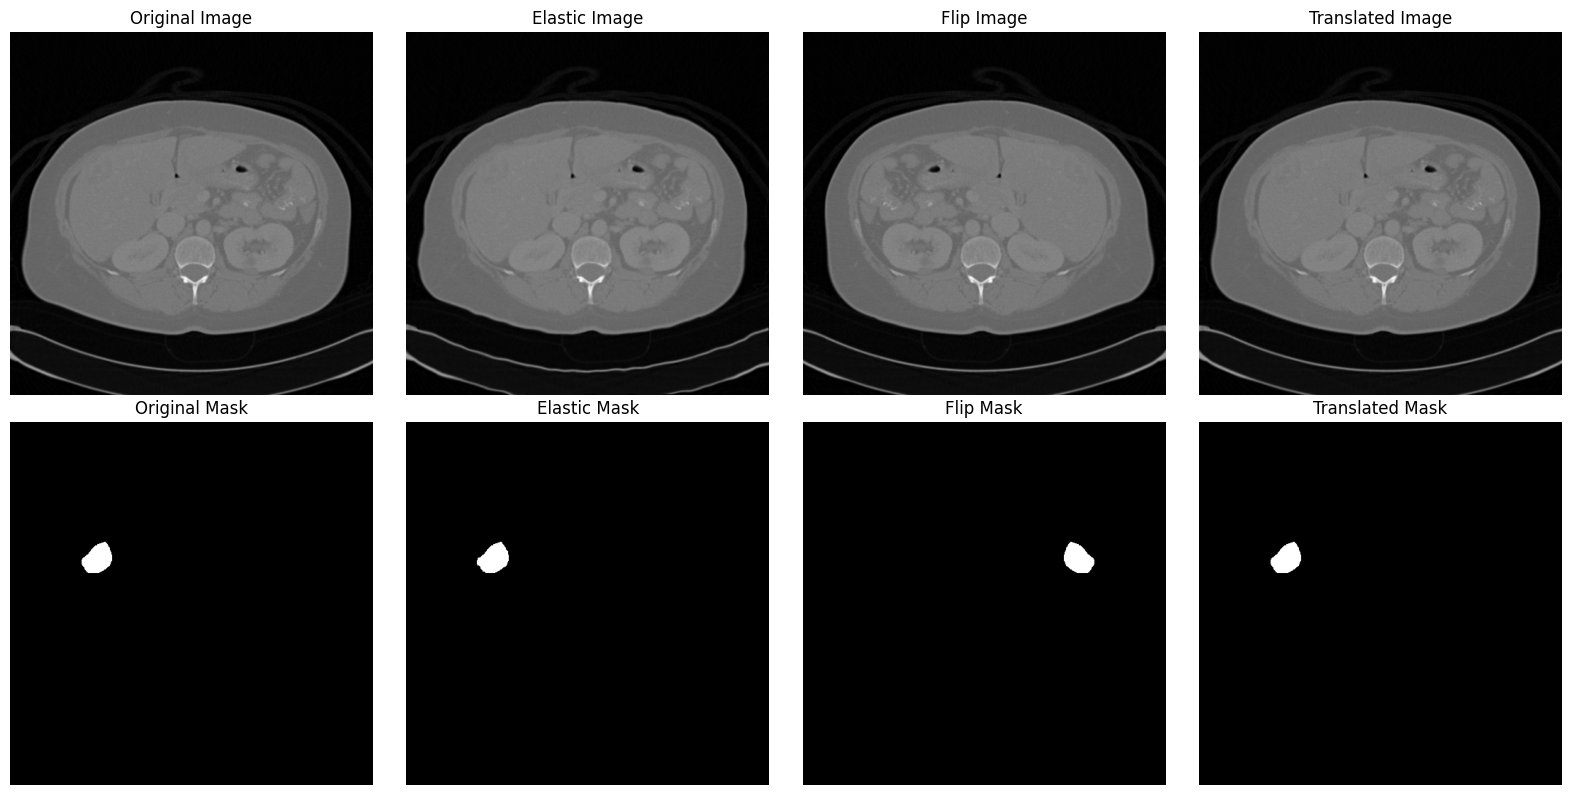

In [10]:
import os
import cv2
import matplotlib.pyplot as plt

# Set base directory
base_dir = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/train_aug_with_hflip"
image_dir = os.path.join(base_dir, "images")
mask_dir = os.path.join(base_dir, "masks")

# Get a list of unique base filenames (e.g., 0001, without augmentation suffixes)
base_filenames = sorted(set(f.split('.')[0].split('_')[0] for f in os.listdir(image_dir) if f.endswith('.png')))

# Function to load image safely
def safe_load_img(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img if img is not None else np.zeros((512, 512), dtype=np.uint8)

# Select the first available sample for visualization
sample_id = base_filenames[200] if base_filenames else None

# Create paths
image_paths = {
    "Original Image": os.path.join(image_dir, f"{sample_id}.png"),
    "Elastic Image": os.path.join(image_dir, f"{sample_id}_elastic.png"),
    "Flip Image": os.path.join(image_dir, f"{sample_id}_hflip.png"),
    "Translated Image": os.path.join(image_dir, f"{sample_id}_trans.png"),
}

mask_paths = {
    "Original Mask": os.path.join(mask_dir, f"{sample_id}.png"),
    "Elastic Mask": os.path.join(mask_dir, f"{sample_id}_elastic.png"),
    "Flip Mask": os.path.join(mask_dir, f"{sample_id}_hflip.png"),
    "Translated Mask": os.path.join(mask_dir, f"{sample_id}_trans.png"),
}

# Plotting
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for idx, (title, path) in enumerate(image_paths.items()):
    axes[0, idx].imshow(safe_load_img(path), cmap='gray')
    axes[0, idx].set_title(title)
    axes[0, idx].axis('off')

for idx, (title, path) in enumerate(mask_paths.items()):
    axes[1, idx].imshow(safe_load_img(path), cmap='gray')
    axes[1, idx].set_title(title)
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()


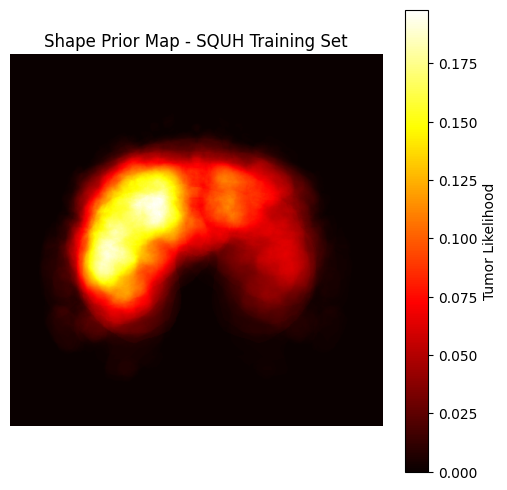

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the path to the SQUH training masks (augmented version)
mask_folder = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/train_aug_with_hflip/masks"

# Initialize accumulator for all masks
accumulator = None
mask_count = 0

# Loop through all mask files
for fname in os.listdir(mask_folder):
    if fname.endswith('.png'):
        path = os.path.join(mask_folder, fname)
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            mask = mask / 255.0  # Normalize to [0, 1]
            if accumulator is None:
                accumulator = np.zeros_like(mask, dtype=np.float32)
            accumulator += mask
            mask_count += 1

# Compute the shape prior map (pixel-wise average)
shape_prior_map = accumulator / mask_count if mask_count > 0 else None

# Plot the shape prior heatmap
plt.figure(figsize=(6, 6))
plt.imshow(shape_prior_map, cmap='hot')
plt.title('Shape Prior Map - SQUH Training Set')
plt.axis('off')
plt.colorbar(label='Tumor Likelihood')
plt.show()


In [ ]:
from pathlib import Path
import imageio.v2 as imageio
import numpy as np
import random

# --- Set your split folder (choose one: train / test / valid)
split = "train"  # or "test", "valid"

root_dir = Path("/content/drive/MyDrive/SQU_split_tumor_80_10_10")
img_dir  = root_dir / split / "images"
msk_dir  = root_dir / split / "masks"

# Get all image paths
image_files = sorted(list(img_dir.glob("*.png")))
mask_files  = sorted(list(msk_dir.glob("*.png")))

# Ensure names match
assert [img.name for img in image_files] == [msk.name for msk in mask_files], "Filenames do not match"

# Sample 10 random pairs
sample_paths = random.sample(image_files, 10)

# Check intensity stats
for img_path in sample_paths:
    mask_path = msk_dir / img_path.name
    img  = imageio.imread(img_path)
    mask = imageio.imread(mask_path)

    print(f" {img_path.name}")
    print(f"  Image shape: {img.shape} | dtype: {img.dtype}")
    print(f"  Image intensity: min={img.min()}, max={img.max()}, unique={np.unique(img)}")
    print(f"  Mask values: unique={np.unique(mask)}")
    print("-" * 50)


 0441.png
  Image shape: (512, 512) | dtype: uint8
  Image intensity: min=0, max=255, unique=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 22

###Step6:Prepare preprocessing pipeline before modeling

Loads images and masks by filename from given directories.

Performs min-max normalization on each image individually:
scales pixel intensities to
0
,
1
0,1 based on that image's min and max values.

Binarizes masks to 0 or 1.

Resizes both image and mask to a fixed size (default 512×512).

Adds a channel dimension so images/masks are (H, W, 1).

Supports batching and shuffling to feed data efficiently during training.

Suitable for Keras model .fit() as a data generator.



In [ ]:
import os
import random
import numpy as np
import cv2
import gc
import tensorflow as tf

class DataGen(tf.keras.utils.Sequence):
    """
    Custom data generator for grayscale PNG images and binary masks.
    Performs per-image min-max normalization scaling each image to [0, 1].
    Masks are binarized to {0,1} and resized.
    """

    def __init__(self, image_ids, img_path, mask_path, batch_size=32, image_size=512, shuffle=True):
        self.ids = image_ids
        self.img_path = img_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __load__(self, item):
        full_image_path = os.path.join(self.img_path, item)
        full_mask_path = os.path.join(self.mask_path, item)

        # Load grayscale image as float32
        image = cv2.imread(full_image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

        # Per-image min-max normalization
        img_min = image.min()
        img_max = image.max()
        if img_max > img_min:
            image = (image - img_min) / (img_max - img_min)
        else:
            image = np.zeros_like(image)  # if image is constant, set zeros

        # Load mask and binarize
        mask = cv2.imread(full_mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        mask = (mask >= 255).astype(np.float32)

        # Resize image and mask
        image = cv2.resize(image, (self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

        # Add channel dimension
        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.ids):
            current_batch_size = len(self.ids) - index * self.batch_size
        else:
            current_batch_size = self.batch_size

        batch_ids = self.ids[index * self.batch_size : index * self.batch_size + current_batch_size]
        images, masks = zip(*(self.__load__(item) for item in batch_ids))

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.ids)
        gc.collect()

    def __len__(self):
        return int(np.ceil(len(self.ids) / float(self.batch_size)))


In [ ]:
train_gen = DataGen(
    image_ids=train_image_ids,
    img_path=train_img_path,
    mask_path=train_mask_path,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)

valid_gen = DataGen(
    image_ids=valid_image_ids,
    img_path=valid_img_path,
    mask_path=valid_mask_path,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False
)

test_gen = DataGen(
    image_ids=test_image_ids,
    img_path=test_img_path,
    mask_path=test_mask_path,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False  # usually test sets are not shuffled
)
